In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Define the hyperparameter search space for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [5]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

# Define your parameter grid here
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        print(f"\n--- Processing Fold {fold} ---")
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='mlogloss')
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = XGBClassifier(**best_params, random_state=random_state, use_label_encoder=False, eval_metric='mlogloss')
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC Calculation
        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        # Classification report
        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Average Metrics
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature Importance
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)

    print("\nFeature Importances:")
    print(feature_importances)

    return best_model, best_scaler, best_fold, all_metrics



=== Training Phase 1 ===

--- Processing Fold 1 ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84      1785
           1       0.63      0.39      0.48       604
           2       0.51      0.35      0.41       258
           3       0.48      0.36      0.41        59
           4       0.00      0.00      0.00         9

    accuracy                           0.73      2715
   macro avg       0.48      0.40      0.43      2715
weighted avg       0.71      0.73      0.71      2715



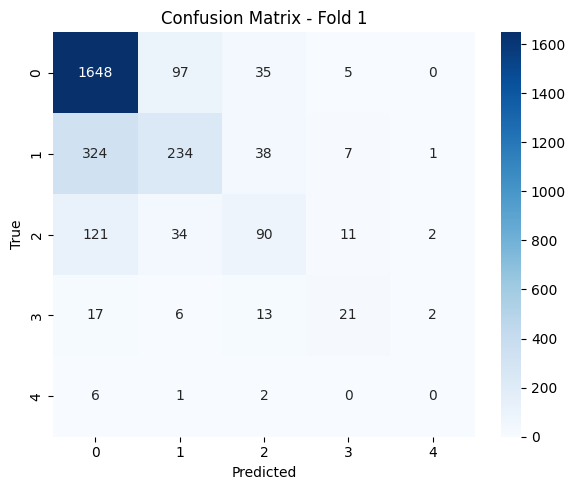

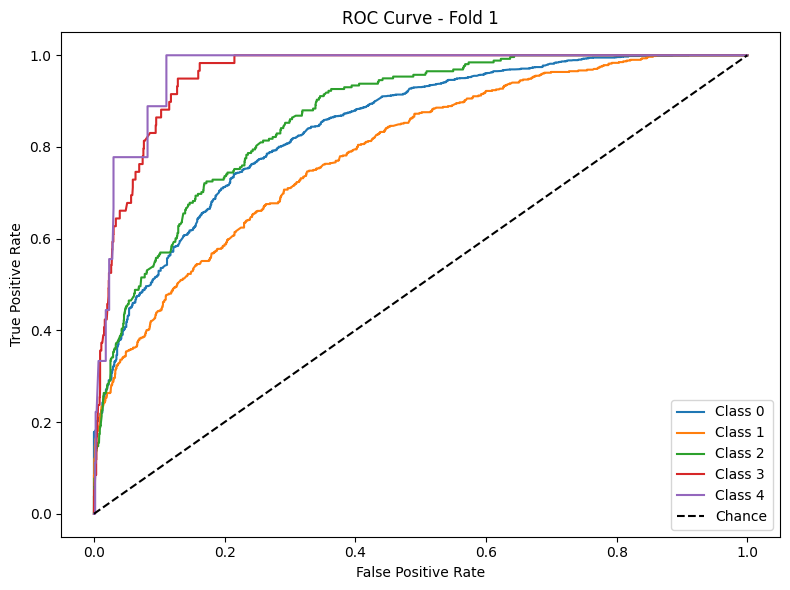


--- Processing Fold 2 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84      1786
           1       0.58      0.37      0.45       603
           2       0.58      0.40      0.47       258
           3       0.38      0.27      0.32        59
           4       0.00      0.00      0.00         8

    accuracy                           0.73      2714
   macro avg       0.46      0.39      0.41      2714
weighted avg       0.70      0.73      0.70      2714



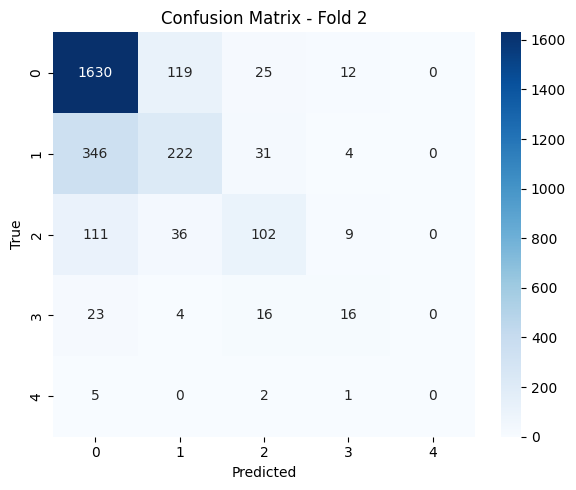

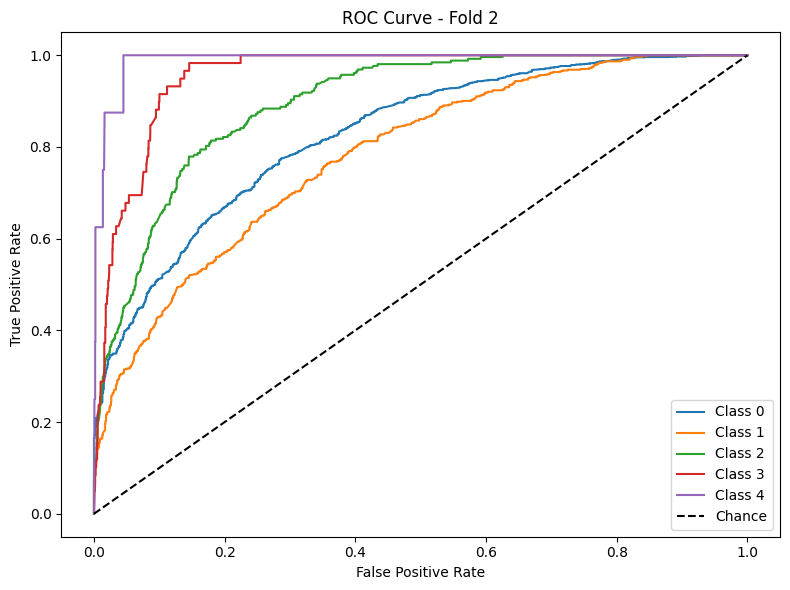


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84      1786
           1       0.60      0.41      0.49       603
           2       0.48      0.35      0.41       258
           3       0.49      0.36      0.41        59
           4       0.33      0.25      0.29         8

    accuracy                           0.73      2714
   macro avg       0.54      0.45      0.49      2714
weighted avg       0.71      0.73      0.71      2714



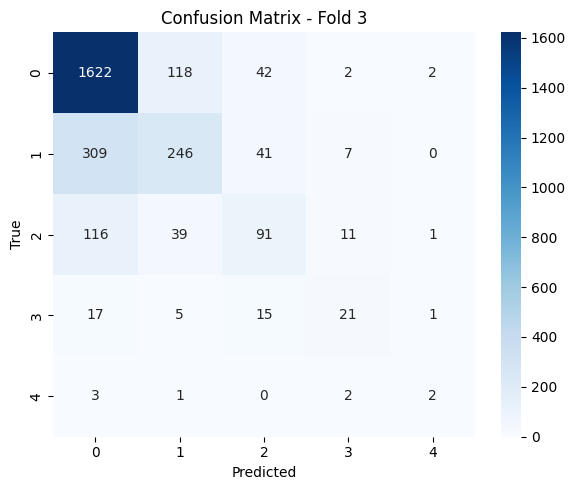

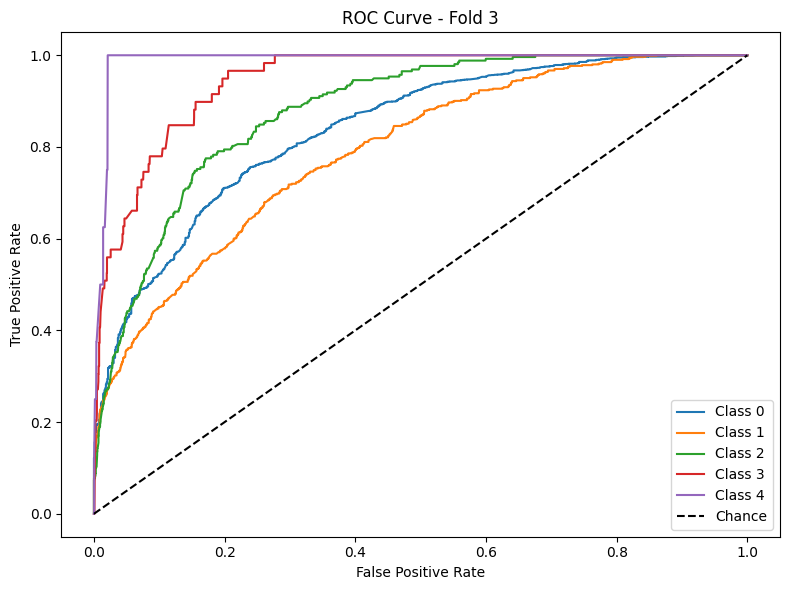


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85      1785
           1       0.62      0.43      0.51       603
           2       0.60      0.43      0.50       258
           3       0.33      0.20      0.25        59
           4       1.00      0.11      0.20         9

    accuracy                           0.74      2714
   macro avg       0.67      0.42      0.46      2714
weighted avg       0.72      0.74      0.72      2714



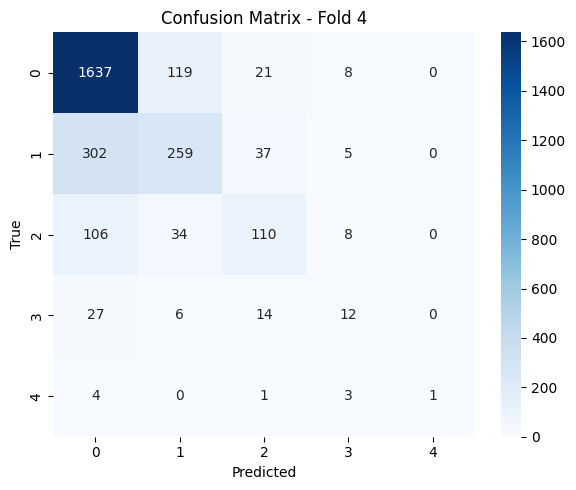

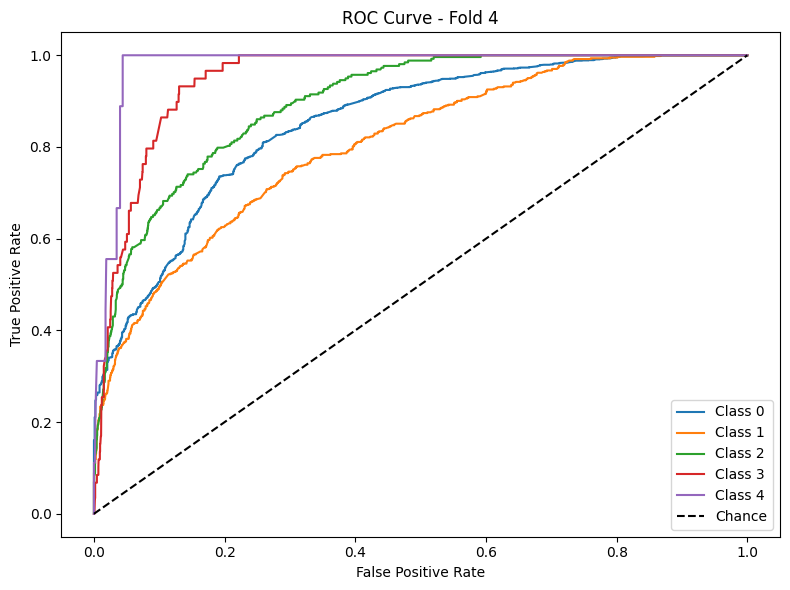


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85      1785
           1       0.61      0.37      0.46       603
           2       0.57      0.39      0.46       258
           3       0.38      0.25      0.31        59
           4       1.00      0.11      0.20         9

    accuracy                           0.74      2714
   macro avg       0.67      0.41      0.46      2714
weighted avg       0.71      0.74      0.71      2714



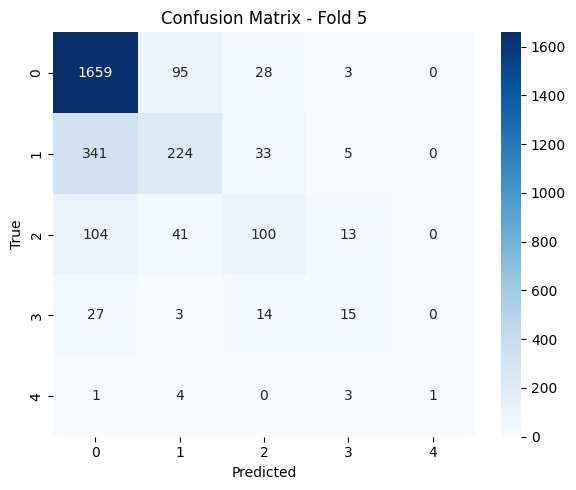

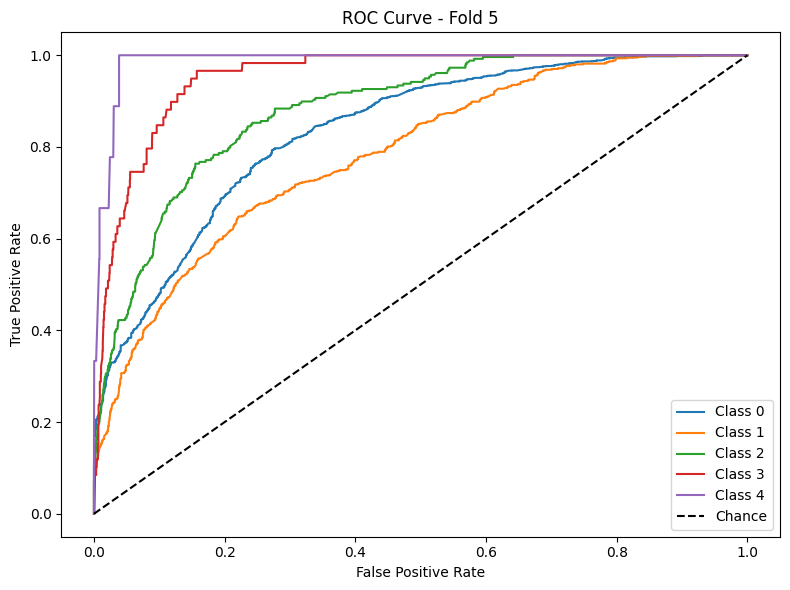


Average Accuracy: 0.7341
Average F1 Macro: 0.4494
Average AUC: 0.8897

Feature Importances:
video                                  0.066200
assignment                             0.059643
exercise_correct_sum_1                 0.049407
exercise_perc_real_score_mean_1        0.041999
certificate                            0.041378
exam                                   0.036274
exercise_id_count_1                    0.035846
duration_days                          0.035505
exercise_num_problem_sum_1             0.034961
exercise_count                         0.033018
exercise_context_sum_1                 0.032502
num_prerequisites                      0.030999
encoded_field_sum                      0.029055
end_year                               0.028195
exercise_correct_mean_1                0.027607
degree                                 0.027323
eigenvector                            0.026764
chapter_count                          0.025702
closeness                              0.02

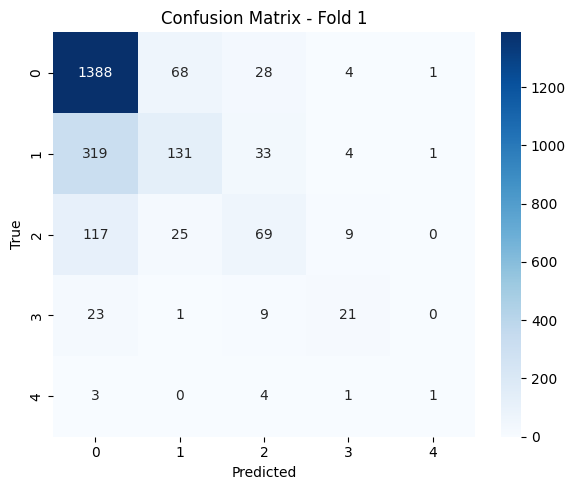

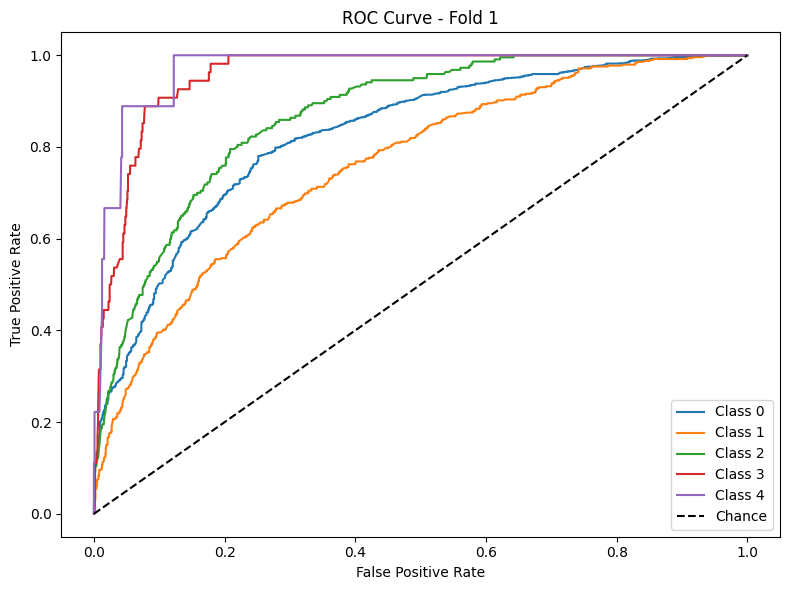


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.83      1489
           1       0.56      0.26      0.36       489
           2       0.52      0.26      0.35       219
           3       0.28      0.24      0.26        55
           4       0.00      0.00      0.00         8

    accuracy                           0.71      2260
   macro avg       0.42      0.34      0.36      2260
weighted avg       0.67      0.71      0.67      2260



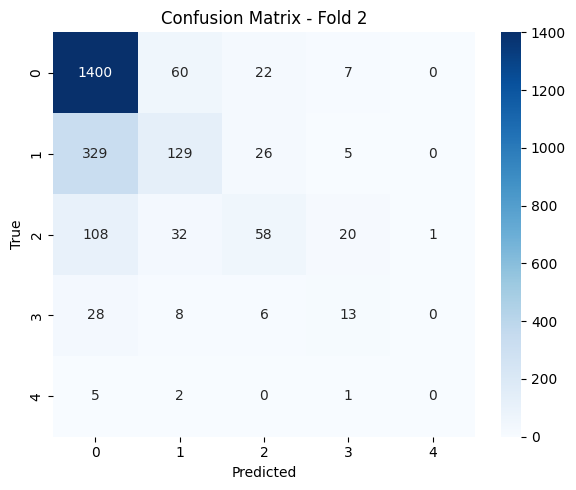

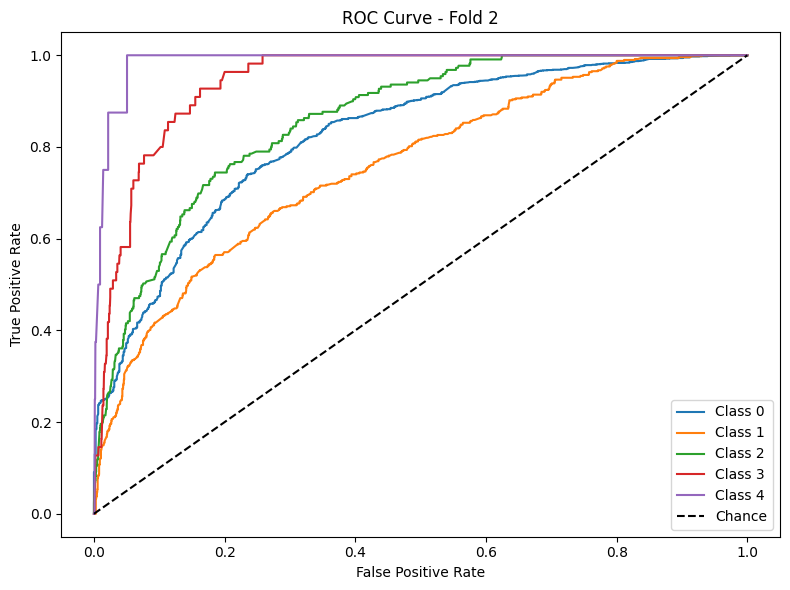


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83      1489
           1       0.55      0.23      0.33       489
           2       0.52      0.30      0.38       219
           3       0.29      0.22      0.25        54
           4       1.00      0.12      0.22         8

    accuracy                           0.71      2259
   macro avg       0.62      0.36      0.40      2259
weighted avg       0.67      0.71      0.66      2259



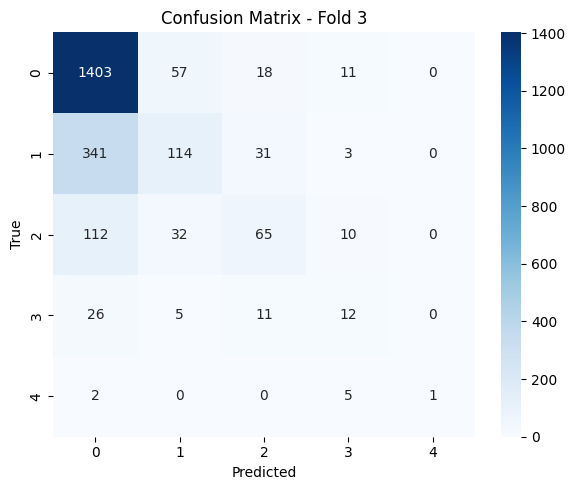

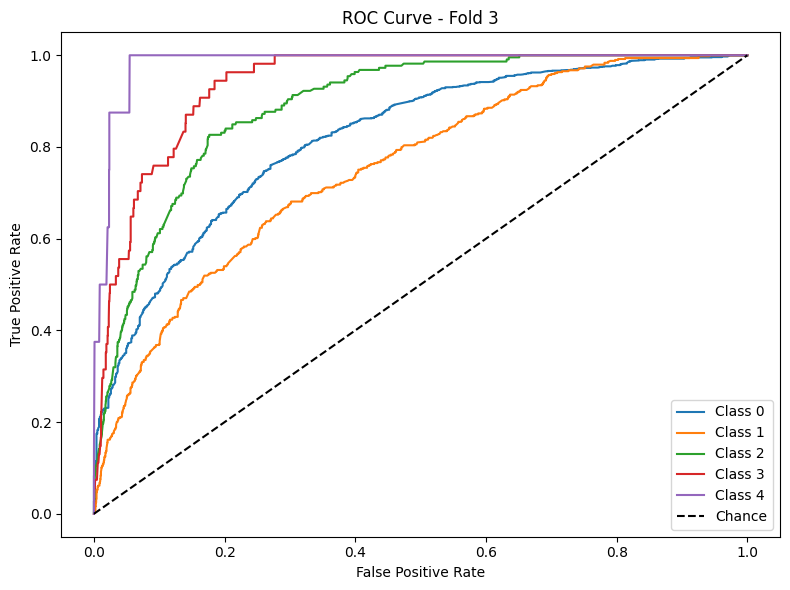


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.83      1489
           1       0.63      0.27      0.38       489
           2       0.50      0.32      0.39       219
           3       0.50      0.39      0.44        54
           4       0.60      0.38      0.46         8

    accuracy                           0.72      2259
   macro avg       0.60      0.46      0.50      2259
weighted avg       0.69      0.72      0.68      2259



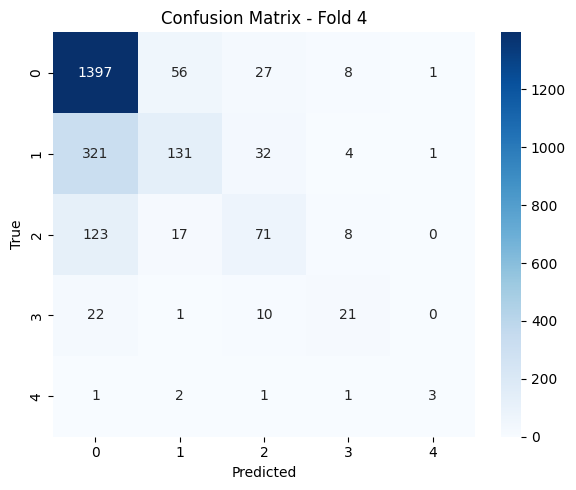

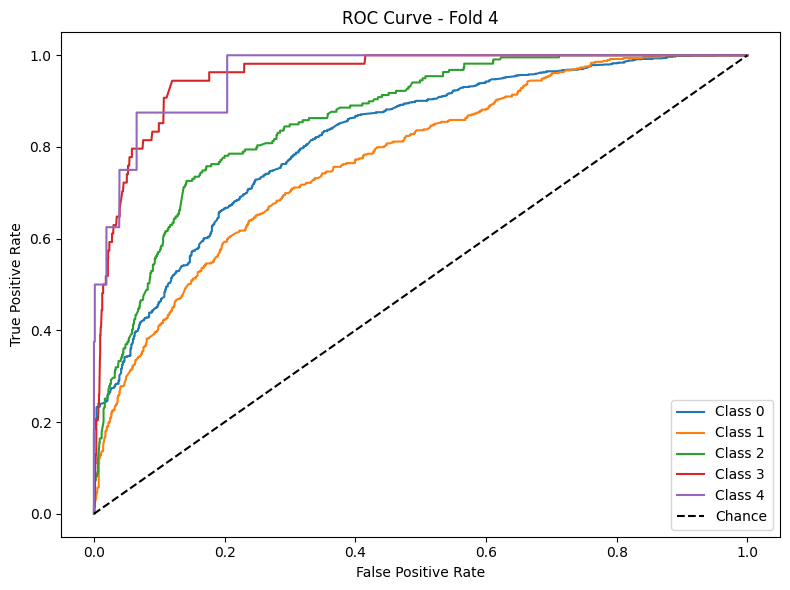


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.84      1490
           1       0.58      0.32      0.42       488
           2       0.48      0.31      0.37       219
           3       0.20      0.07      0.11        54
           4       0.25      0.12      0.17         8

    accuracy                           0.72      2259
   macro avg       0.45      0.35      0.38      2259
weighted avg       0.68      0.72      0.69      2259



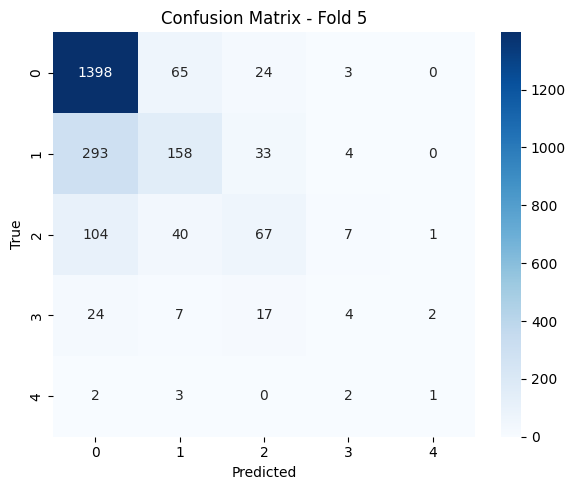

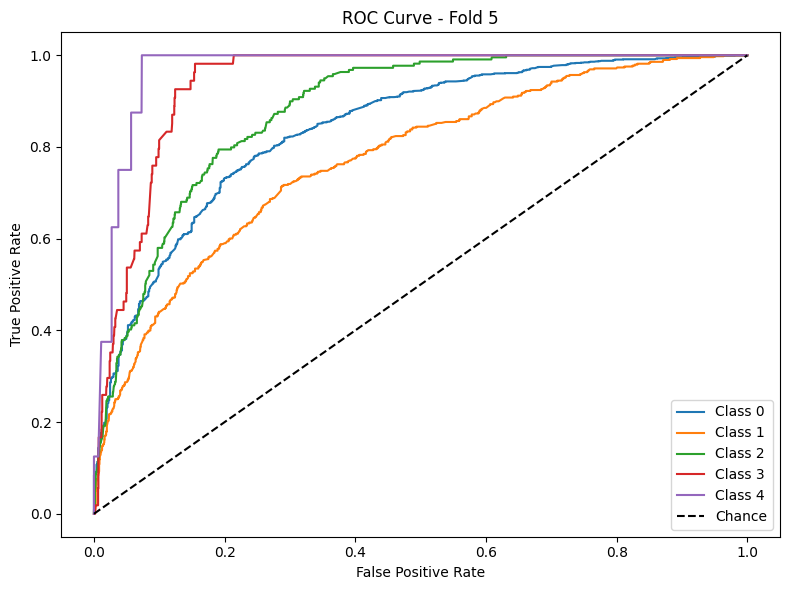


Average Accuracy: 0.7131
Average F1 Macro: 0.4168
Average AUC: 0.8764

Feature Importances:
certificate                            0.065845
video                                  0.055652
assignment                             0.046751
exercise_perc_real_score_mean_2        0.036483
closeness                              0.035245
encoded_field_sum                      0.032188
school                                 0.031047
exercise_count                         0.030172
exercise_context_sum_1                 0.029509
exercise_correct_mean_2                0.027041
exercise_num_problem_sum_1             0.026718
exam                                   0.025775
duration_days                          0.022448
exercise_perc_real_completed_mean_1    0.021845
video_count                            0.021349
cluster                                0.021280
exercise_correct_sum_2                 0.021043
user_time_since_last_course            0.020767
exercise_correct_sum_1                 0.02

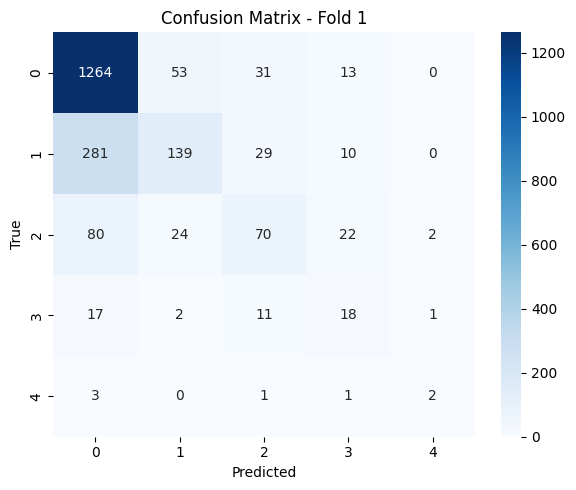

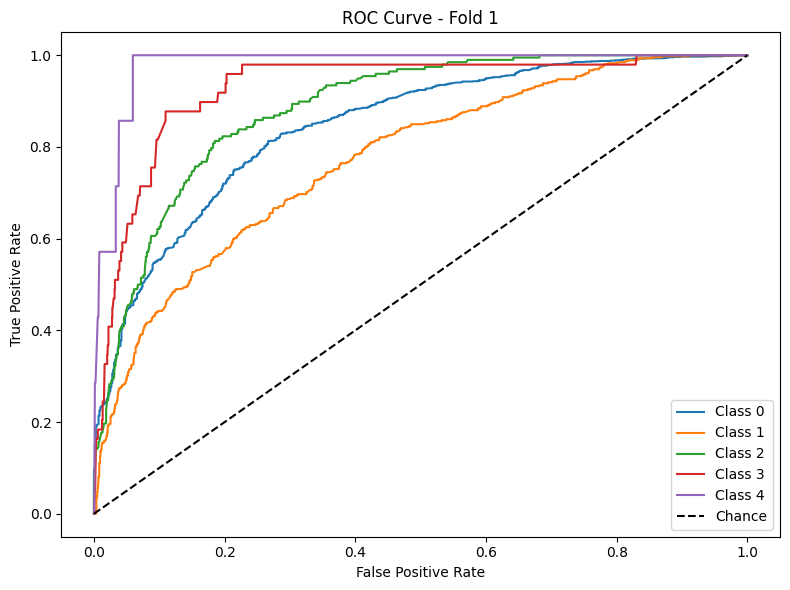


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84      1360
           1       0.56      0.36      0.44       459
           2       0.51      0.38      0.44       198
           3       0.47      0.32      0.38        50
           4       0.00      0.00      0.00         7

    accuracy                           0.72      2074
   macro avg       0.46      0.39      0.42      2074
weighted avg       0.69      0.72      0.70      2074



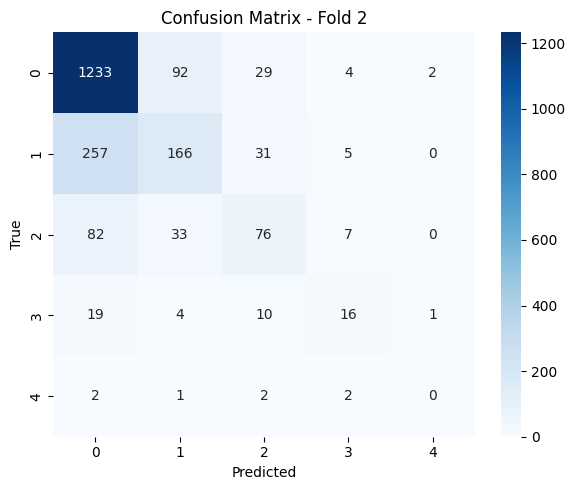

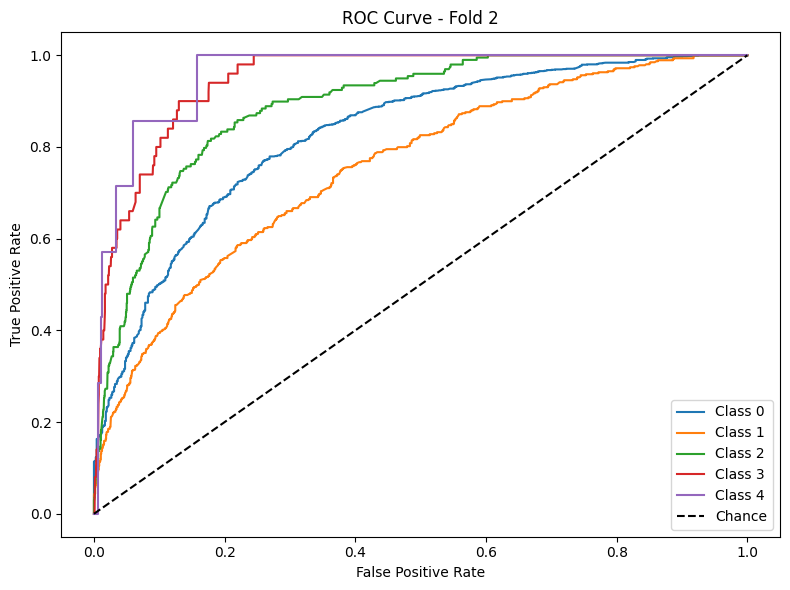


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84      1360
           1       0.55      0.33      0.41       459
           2       0.48      0.39      0.43       198
           3       0.37      0.30      0.33        50
           4       0.00      0.00      0.00         7

    accuracy                           0.72      2074
   macro avg       0.44      0.39      0.40      2074
weighted avg       0.69      0.72      0.69      2074



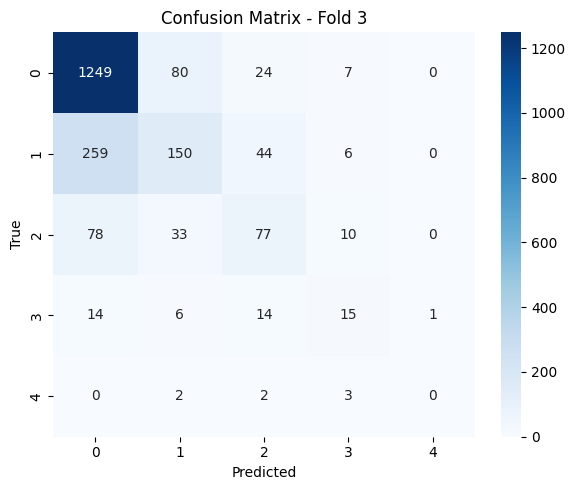

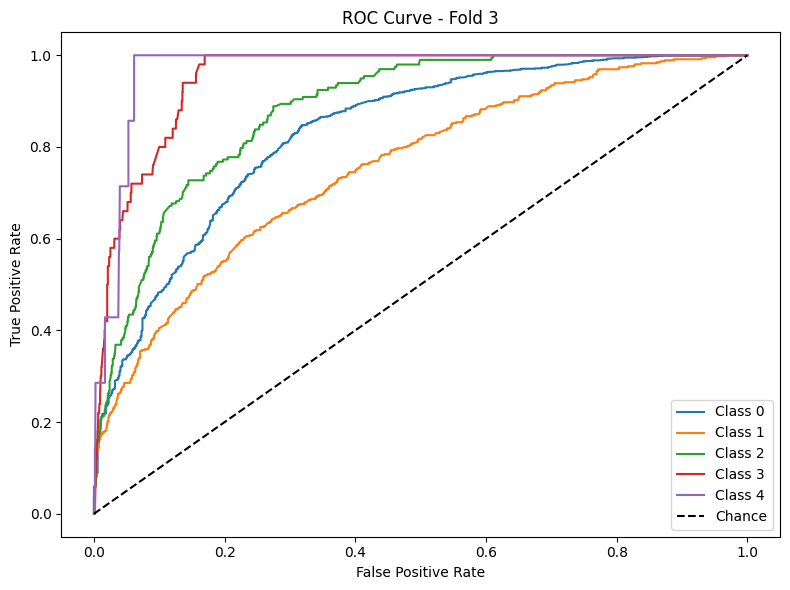


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1360
           1       0.54      0.36      0.44       459
           2       0.50      0.37      0.43       198
           3       0.42      0.34      0.38        50
           4       0.00      0.00      0.00         7

    accuracy                           0.71      2074
   macro avg       0.45      0.40      0.41      2074
weighted avg       0.69      0.71      0.69      2074



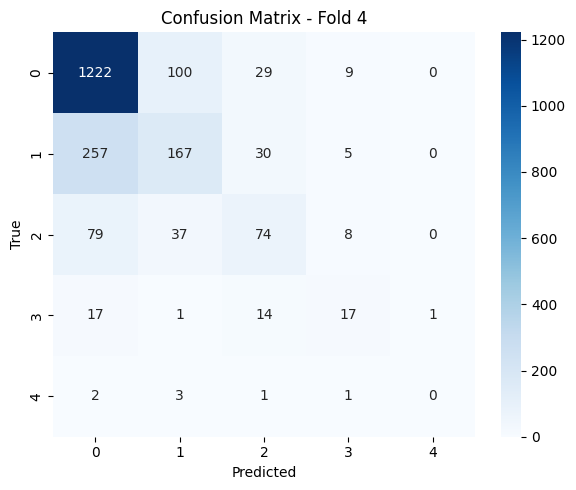

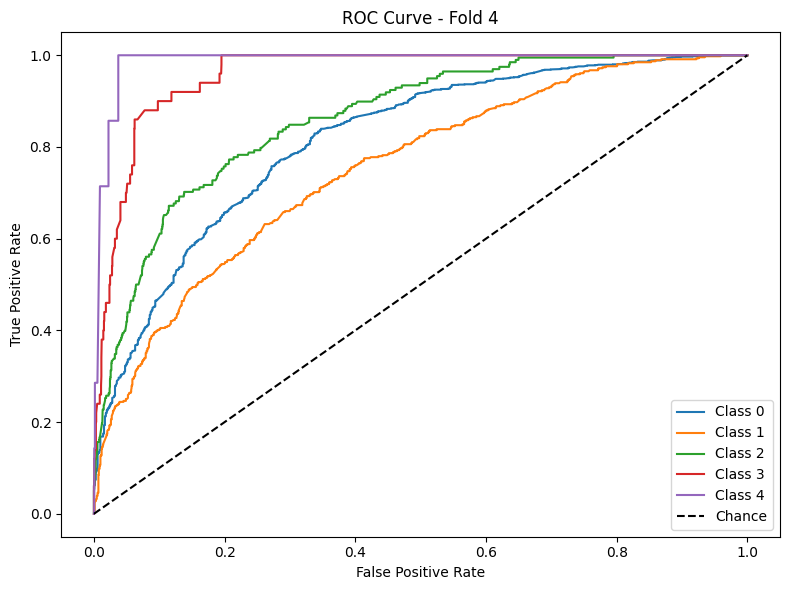


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1360
           1       0.52      0.30      0.38       460
           2       0.44      0.39      0.41       197
           3       0.42      0.31      0.35        49
           4       0.12      0.14      0.13         7

    accuracy                           0.70      2073
   macro avg       0.45      0.41      0.42      2073
weighted avg       0.67      0.70      0.67      2073



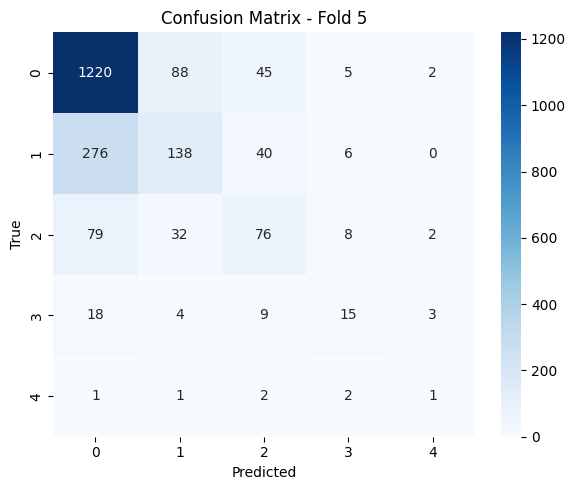

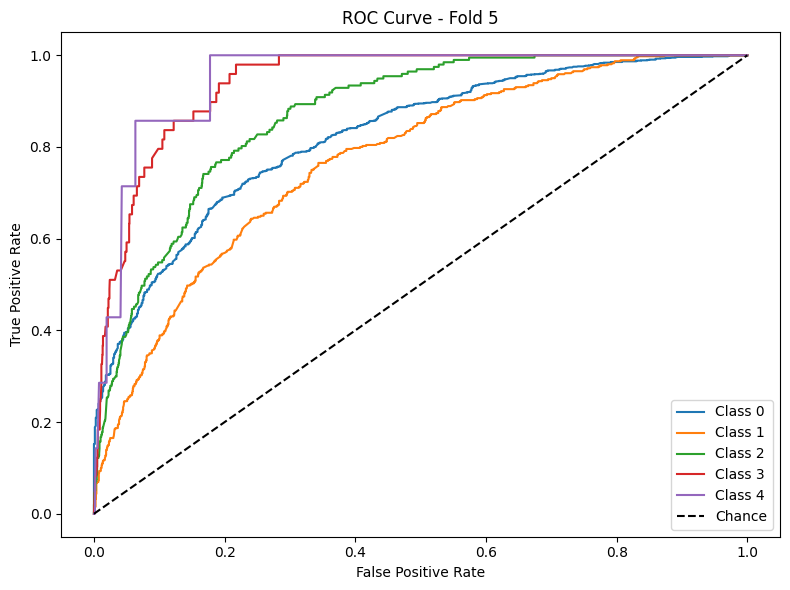


Average Accuracy: 0.7141
Average F1 Macro: 0.4241
Average AUC: 0.8767

Feature Importances:
video                                  0.050022
assignment                             0.033083
exercise_context_sum_1                 0.030907
num_prerequisites                      0.027601
encoded_field_sum                      0.026310
exam                                   0.026006
exercise_context_sum_3                 0.024208
duration_days                          0.024119
exercise_correct_sum_1                 0.023732
video_count                            0.023718
exercise_correct_sum_3                 0.023228
certificate                            0.022507
closeness                              0.021953
exercise_correct_mean_2                0.020494
exercise_context_sum_2                 0.019911
exercise_count                         0.019279
exercise_correct_sum_2                 0.017931
degree                                 0.017101
eigenvector                            0.01

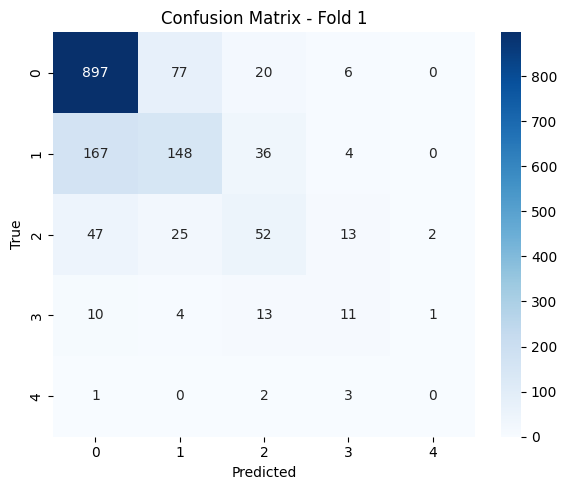

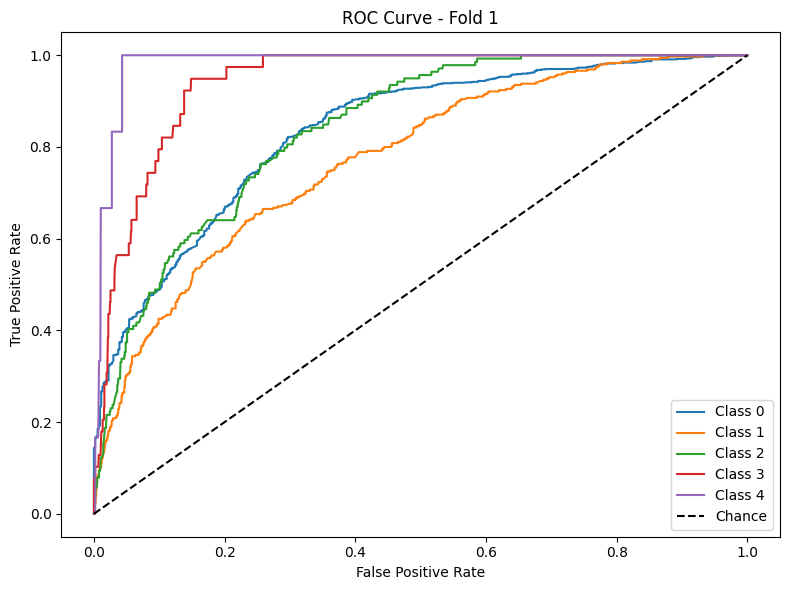


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1000
           1       0.52      0.41      0.46       355
           2       0.52      0.46      0.49       139
           3       0.39      0.30      0.34        40
           4       0.00      0.00      0.00         5

    accuracy                           0.71      1539
   macro avg       0.44      0.41      0.42      1539
weighted avg       0.69      0.71      0.70      1539



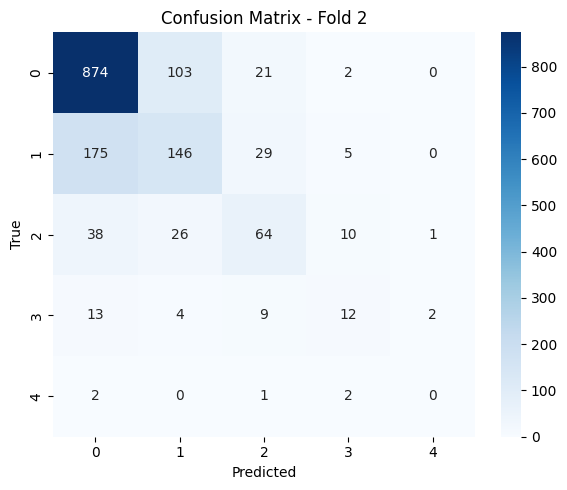

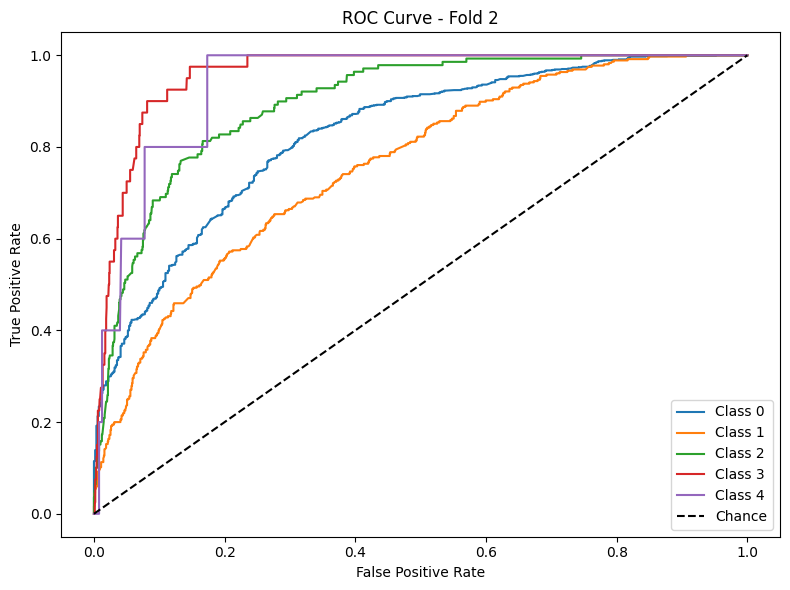


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       999
           1       0.58      0.48      0.52       355
           2       0.51      0.42      0.46       139
           3       0.38      0.38      0.38        40
           4       0.00      0.00      0.00         6

    accuracy                           0.73      1539
   macro avg       0.46      0.43      0.44      1539
weighted avg       0.71      0.73      0.72      1539



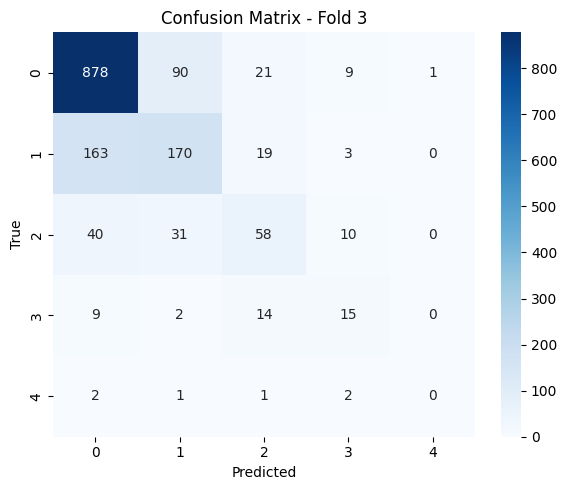

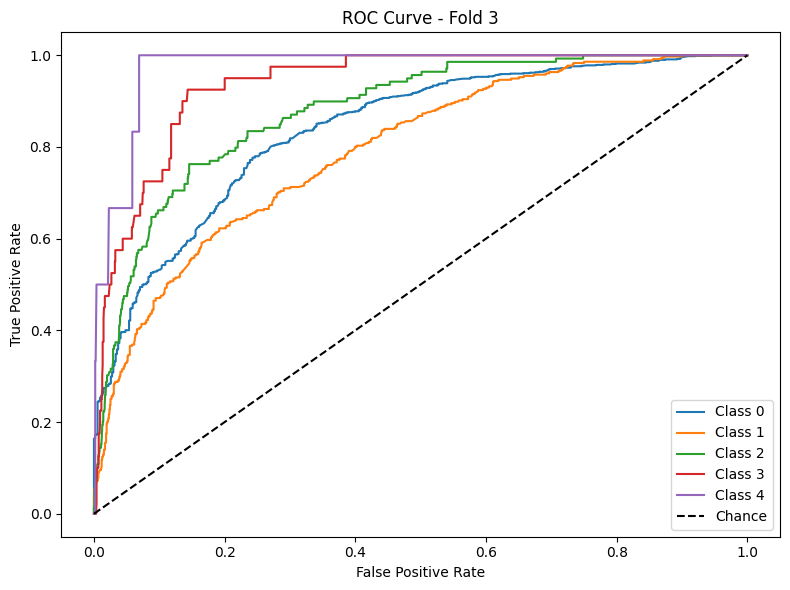


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       999
           1       0.55      0.41      0.47       356
           2       0.46      0.39      0.42       138
           3       0.33      0.31      0.32        39
           4       0.00      0.00      0.00         6

    accuracy                           0.71      1538
   macro avg       0.43      0.40      0.41      1538
weighted avg       0.69      0.71      0.70      1538



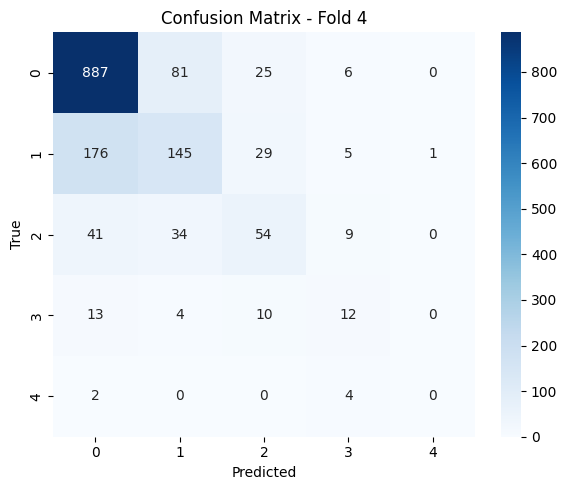

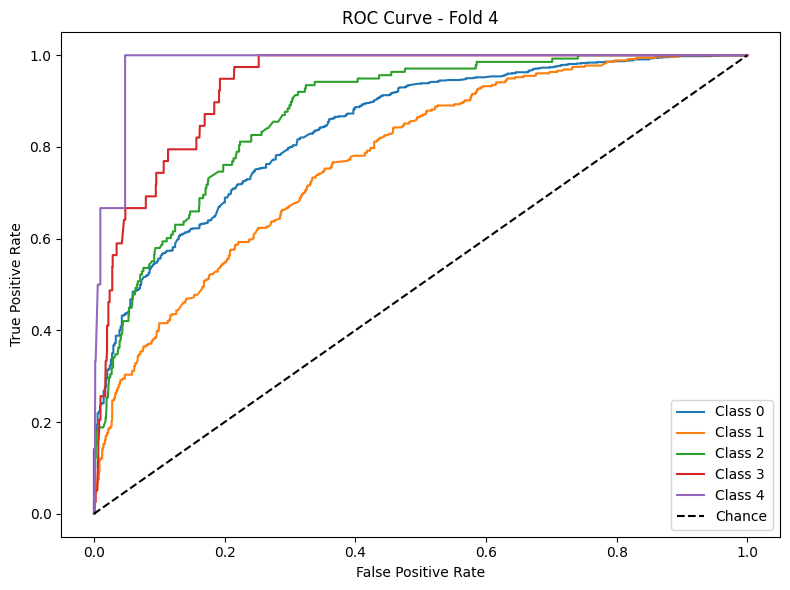


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       999
           1       0.51      0.40      0.45       356
           2       0.48      0.37      0.42       138
           3       0.44      0.46      0.45        39
           4       0.00      0.00      0.00         6

    accuracy                           0.71      1538
   macro avg       0.44      0.42      0.43      1538
weighted avg       0.69      0.71      0.70      1538



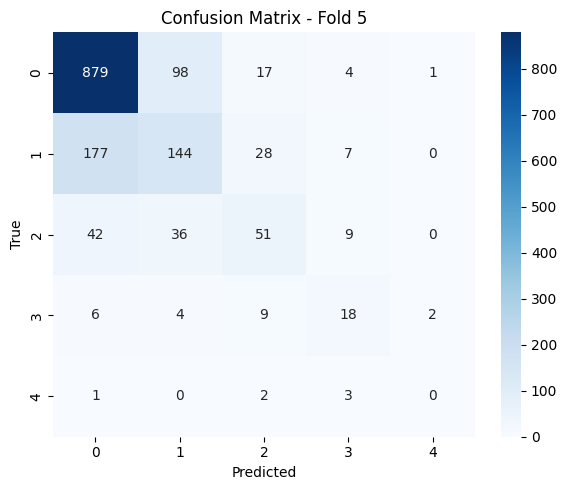

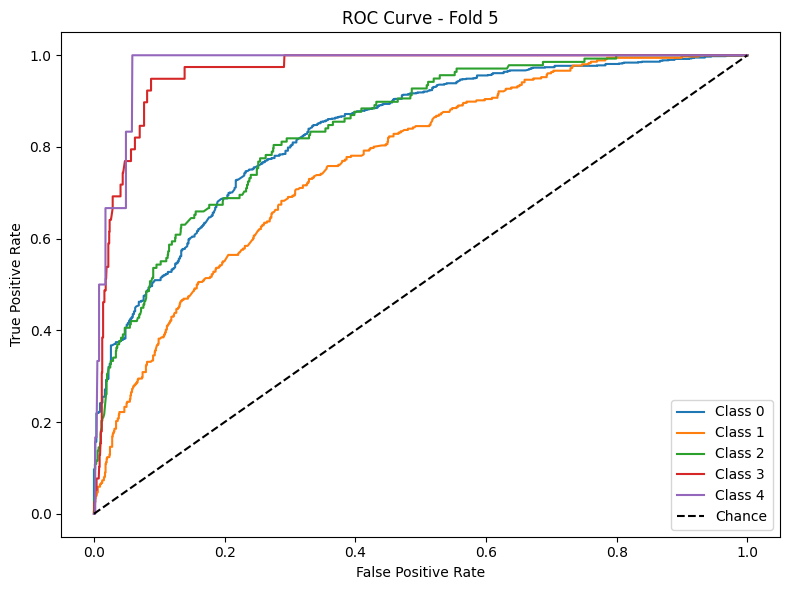


Average Accuracy: 0.7169
Average F1 Macro: 0.4216
Average AUC: 0.8786

Feature Importances:
exercise_num_problem_sum_1             0.035660
exercise_context_sum_4                 0.026147
exercise_hour_entropy_3                0.025727
exercise_correct_sum_2                 0.024362
exercise_id_count_1                    0.023499
exercise_correct_mean_3                0.023015
assignment                             0.021454
exercise_correct_mean_4                0.020338
exercise_correct_mean_2                0.019787
exercise_num_problem_sum_3             0.019551
exercise_langugage_binary_mean_3       0.019030
exercise_correct_sum_1                 0.018734
exercise_context_sum_1                 0.018368
exercise_perc_real_score_mean_2        0.018337
encoded_field_sum                      0.018072
num_prerequisites                      0.017409
exercise_count                         0.017034
video                                  0.016141
exercise_correct_sum_4                 0.01

In [6]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [7]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       568
           1       0.38      0.21      0.27        63
           2       0.38      0.21      0.27        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.83       698
   macro avg       0.33      0.28      0.29       698
weighted avg       0.77      0.83      0.79       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


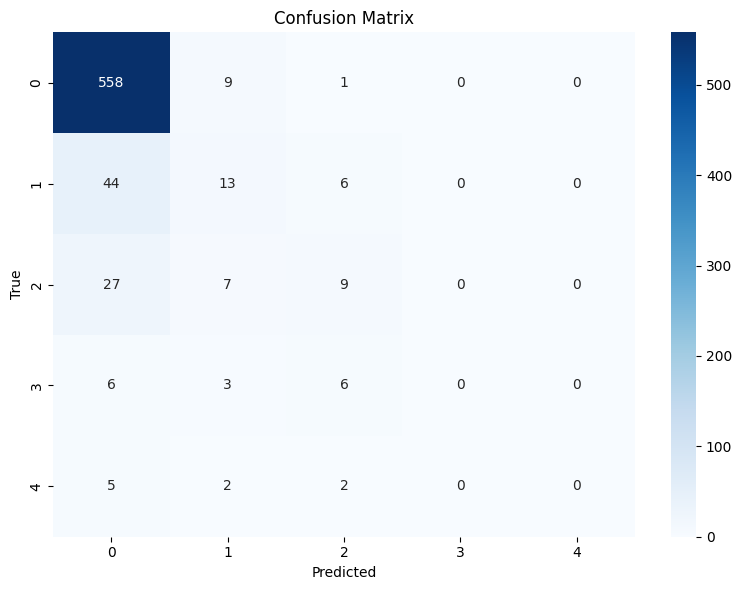


Test AUC (macro-average, OVR): 0.9005


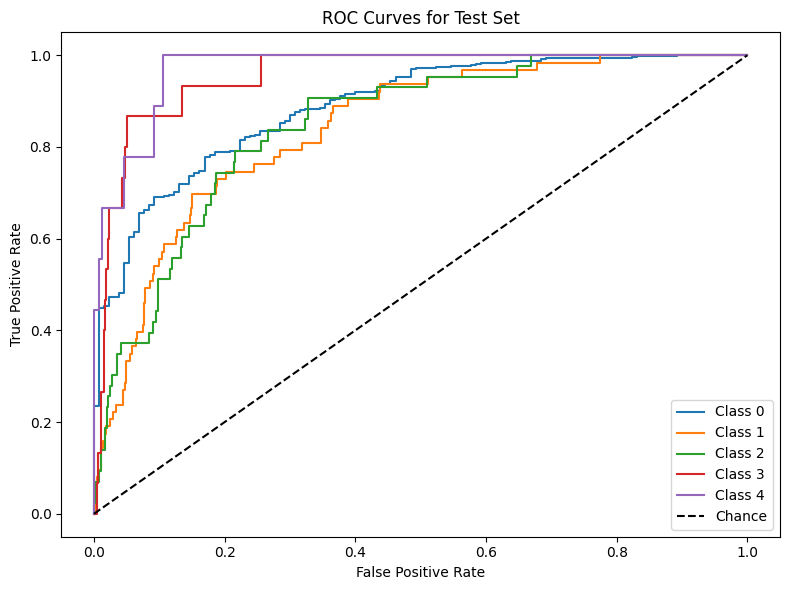


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       544
           1       0.28      0.32      0.30        59
           2       0.30      0.21      0.25        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.30      0.29      0.29       668
weighted avg       0.77      0.81      0.79       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


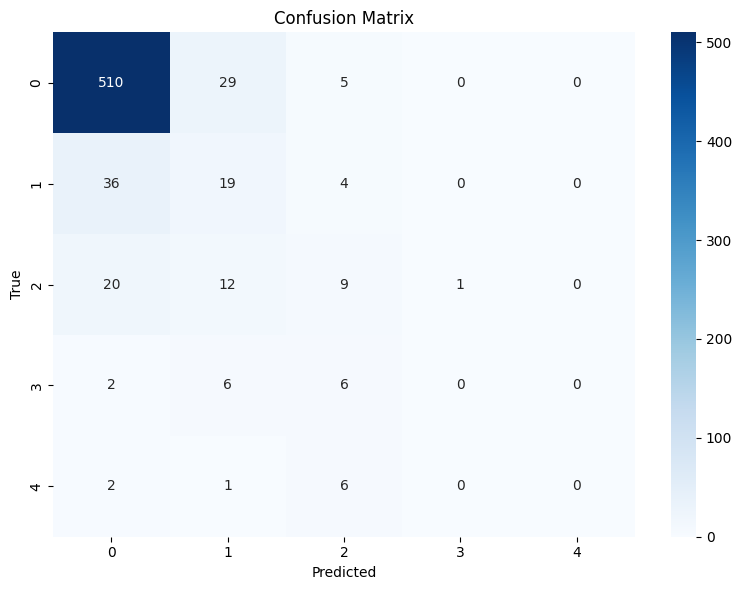


Test AUC (macro-average, OVR): 0.8517


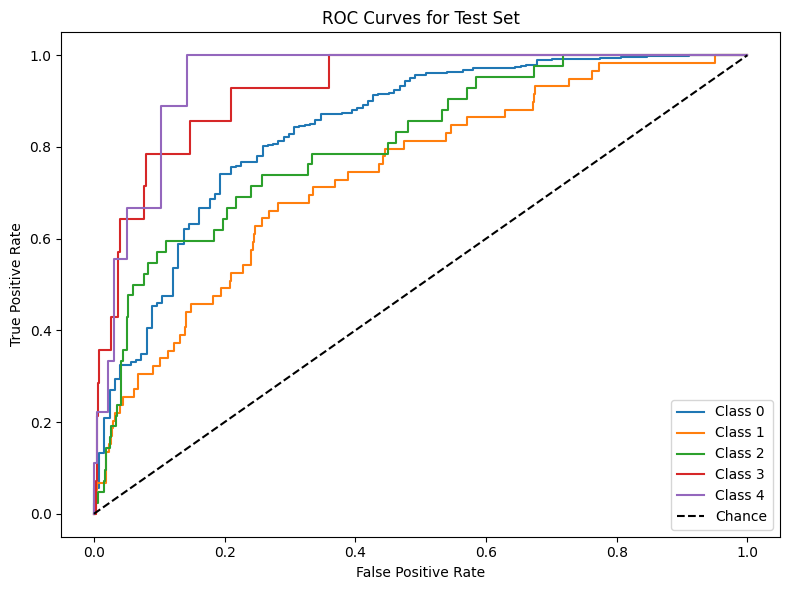


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       455
           1       0.25      0.15      0.19        52
           2       0.17      0.14      0.15        29
           3       0.25      0.10      0.14        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       554
   macro avg       0.31      0.27      0.28       554
weighted avg       0.76      0.81      0.78       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


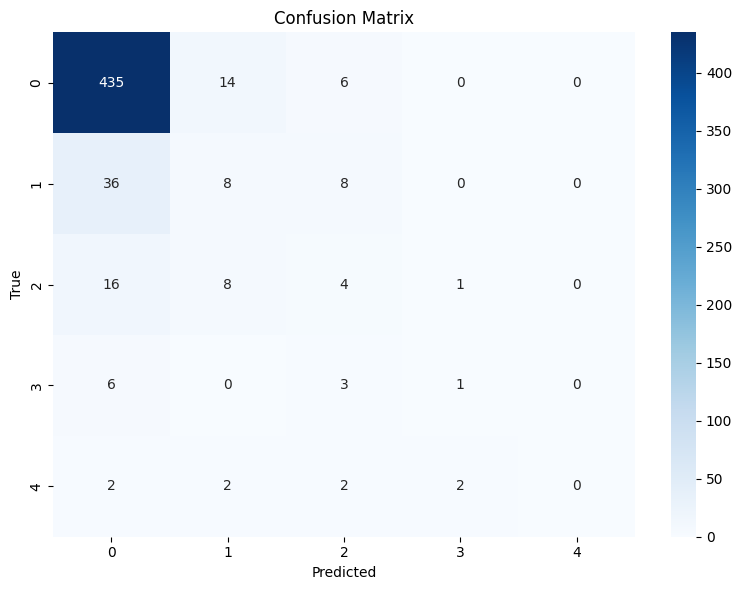


Test AUC (macro-average, OVR): 0.8215


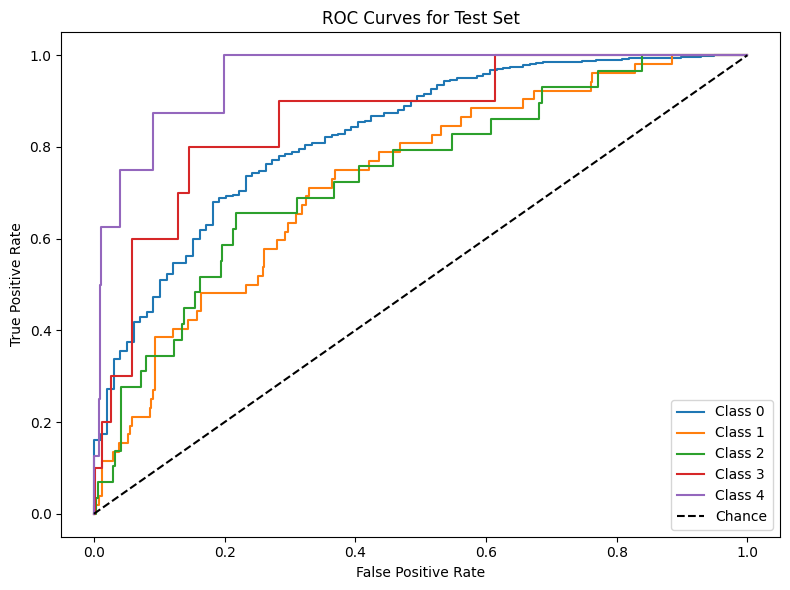


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       395
           1       0.30      0.07      0.12        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.83       477
   macro avg       0.23      0.21      0.21       477
weighted avg       0.73      0.83      0.77       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


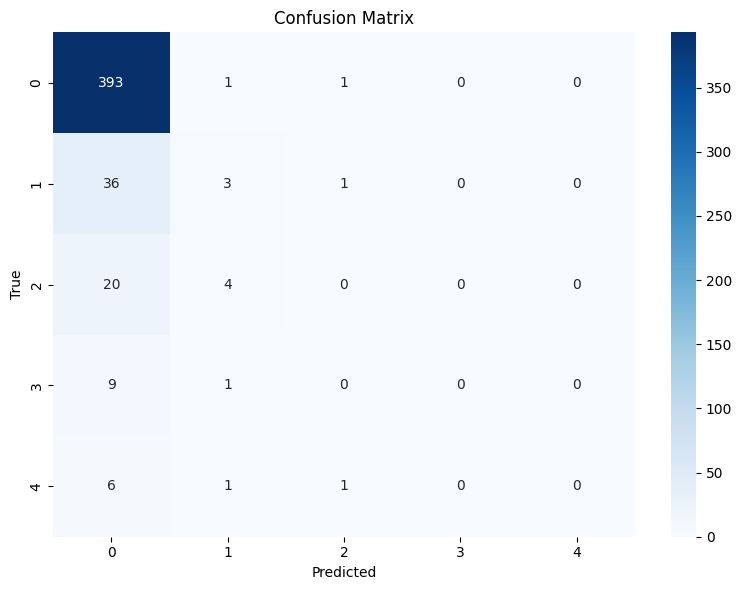


Test AUC (macro-average, OVR): 0.7800


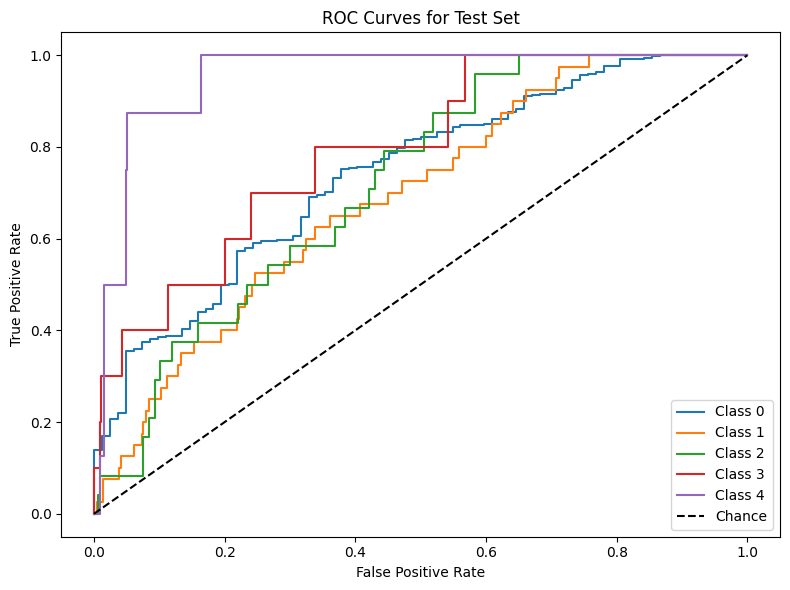

In [8]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===

--- Processing Fold 1 ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      1785
           1       0.56      0.50      0.53       604
           2       0.39      0.52      0.45       258
           3       0.27      0.47      0.34        59
           4       0.09      0.11      0.10         9

    accuracy                           0.70      2715
   macro avg       0.43      0.48      0.45      2715
weighted avg       0.72      0.70      0.71      2715



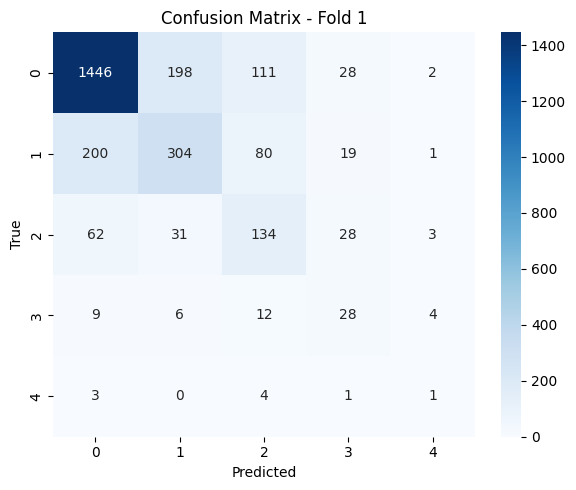

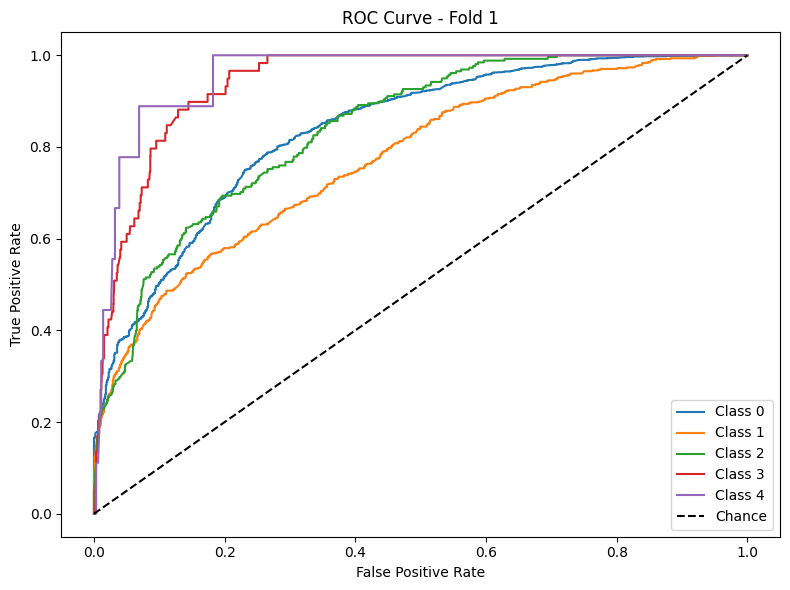


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      1786
           1       0.51      0.46      0.49       603
           2       0.43      0.54      0.48       258
           3       0.27      0.54      0.36        59
           4       0.09      0.12      0.11         8

    accuracy                           0.69      2714
   macro avg       0.43      0.49      0.45      2714
weighted avg       0.71      0.69      0.70      2714



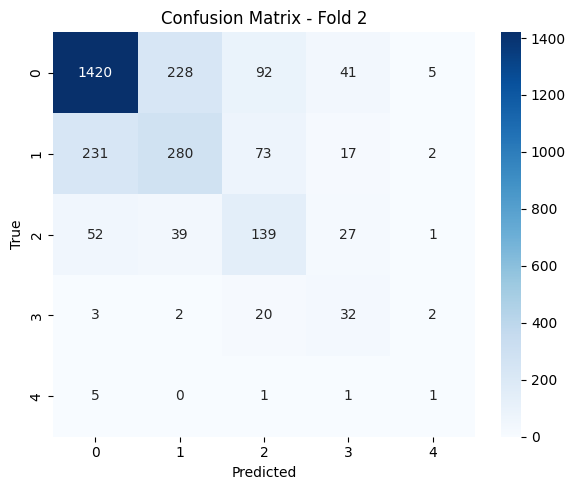

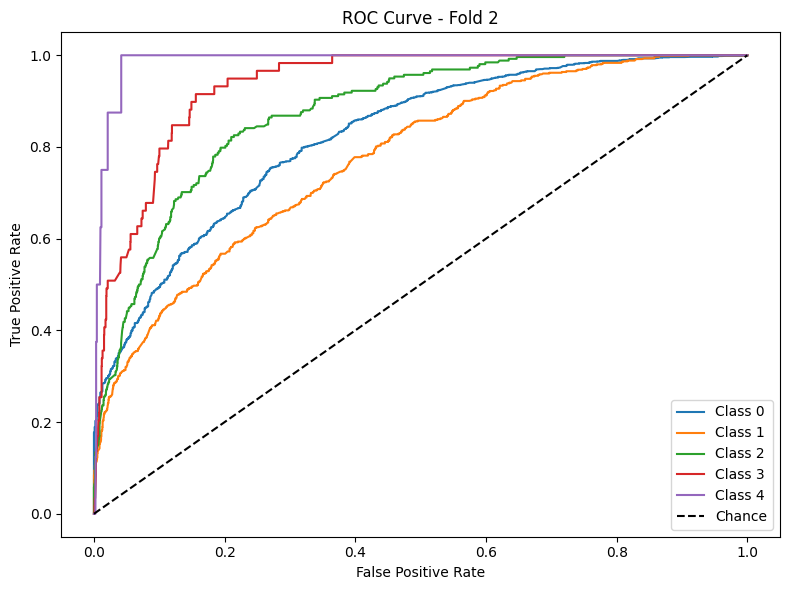


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81      1786
           1       0.51      0.49      0.50       603
           2       0.39      0.57      0.46       258
           3       0.31      0.44      0.36        59
           4       0.18      0.25      0.21         8

    accuracy                           0.69      2714
   macro avg       0.44      0.51      0.47      2714
weighted avg       0.71      0.69      0.69      2714



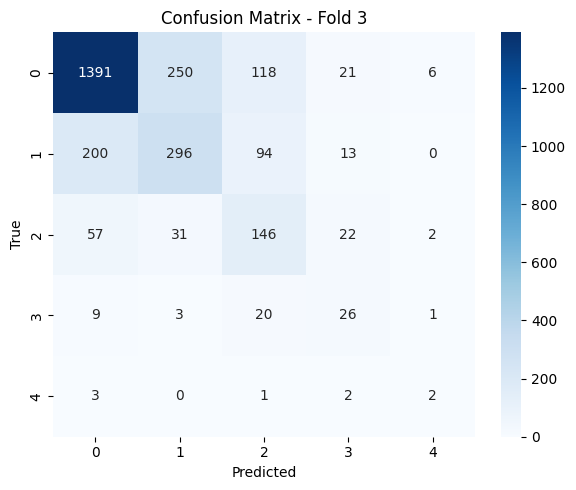

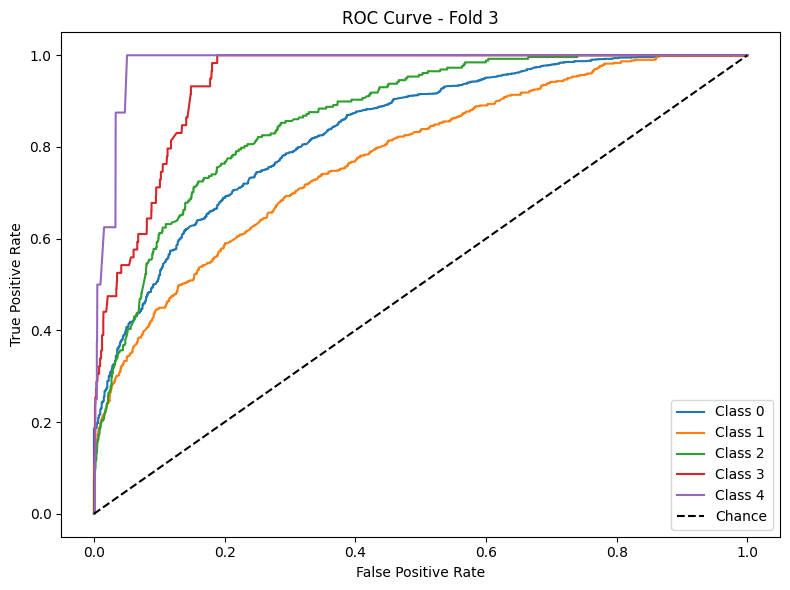


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      1785
           1       0.53      0.50      0.51       603
           2       0.40      0.56      0.47       258
           3       0.23      0.32      0.27        59
           4       0.25      0.11      0.15         9

    accuracy                           0.70      2714
   macro avg       0.45      0.46      0.45      2714
weighted avg       0.72      0.70      0.70      2714



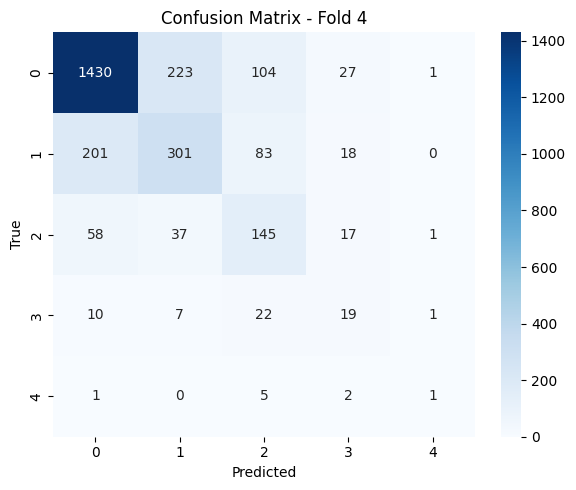

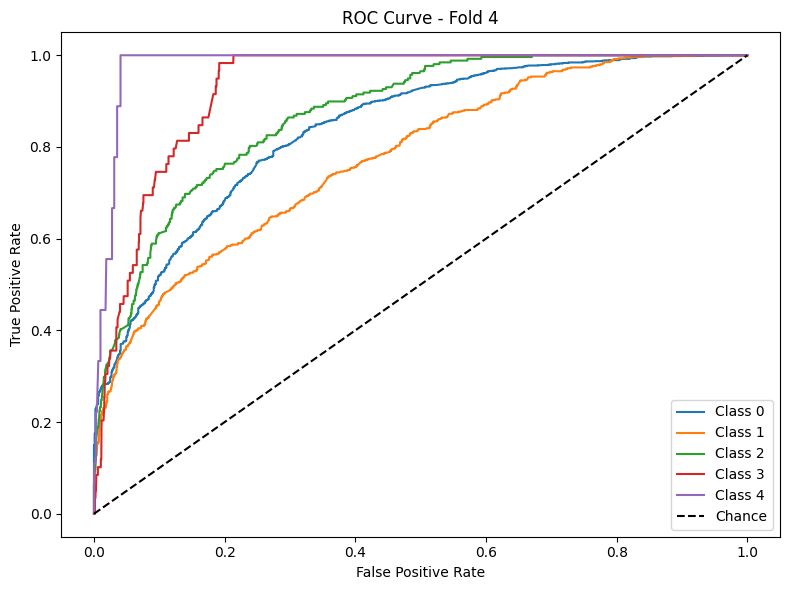


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      1785
           1       0.52      0.47      0.49       603
           2       0.41      0.52      0.46       258
           3       0.21      0.44      0.29        59
           4       0.30      0.33      0.32         9

    accuracy                           0.69      2714
   macro avg       0.46      0.51      0.47      2714
weighted avg       0.71      0.69      0.70      2714



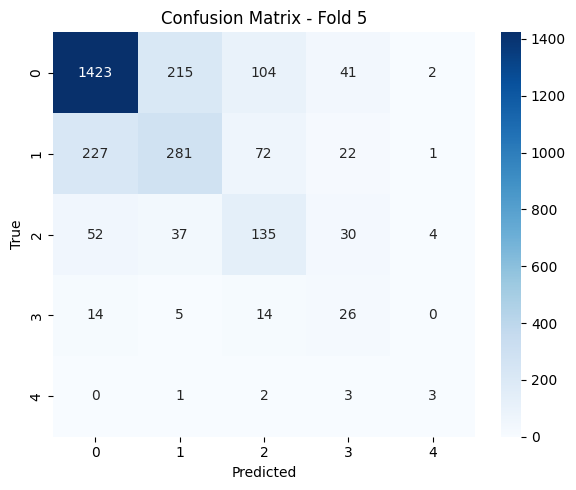

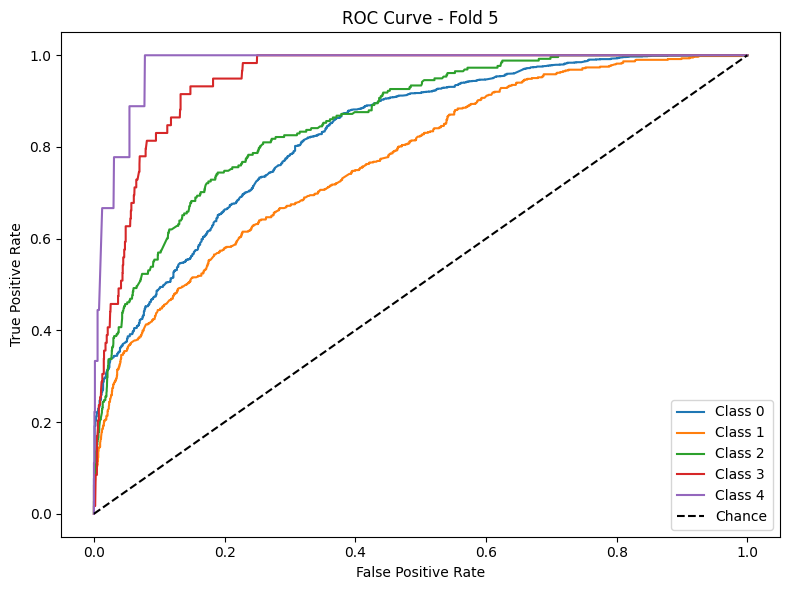


Average Accuracy: 0.6934
Average F1 Macro: 0.4570
Average AUC: 0.8771

Feature Importances:
video                                  0.299261
assignment                             0.077688
exam                                   0.055249
chapter_count                          0.047258
duration_days                          0.045498
exercise_correct_sum_1                 0.045161
end_year                               0.041523
exercise_langugage_binary_mean_1       0.037489
encoded_field_sum                      0.027484
video_count                            0.024306
degree                                 0.021954
exercise_count                         0.020281
certificate                            0.019100
eigenvector                            0.017490
num_prerequisites                      0.016317
exercise_context_sum_1                 0.014762
school                                 0.013784
user_past_course_count                 0.012611
exercise_perc_real_score_mean_1        0.01

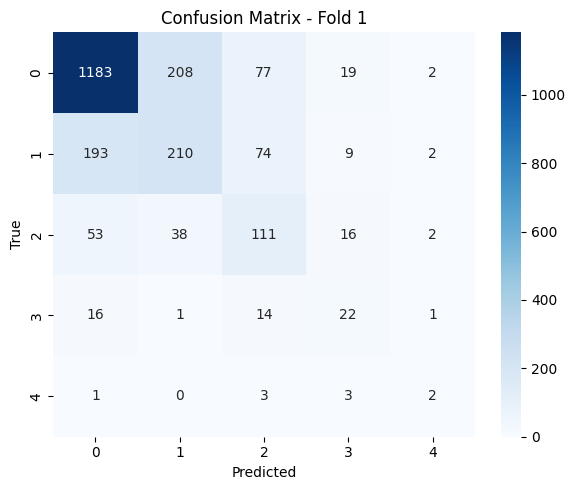

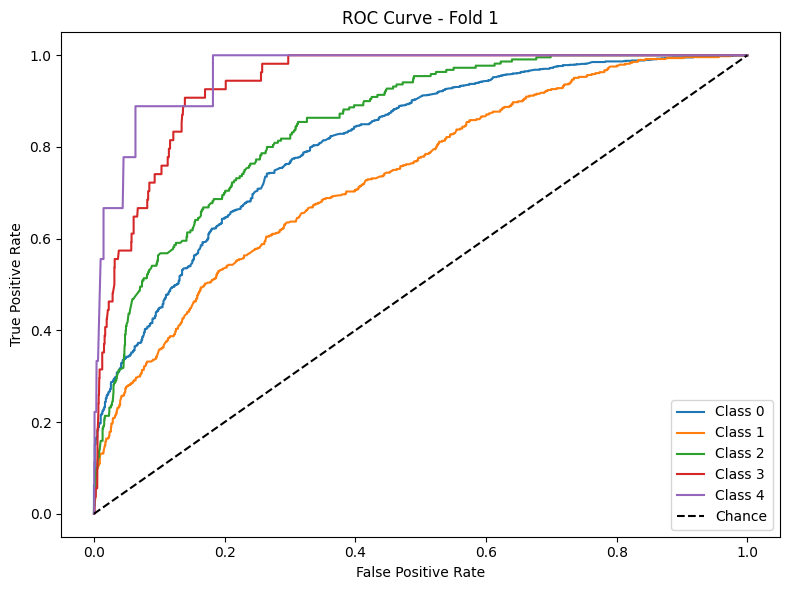


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80      1489
           1       0.47      0.47      0.47       489
           2       0.37      0.43      0.39       219
           3       0.24      0.36      0.29        55
           4       0.30      0.38      0.33         8

    accuracy                           0.67      2260
   macro avg       0.44      0.49      0.46      2260
weighted avg       0.69      0.67      0.68      2260



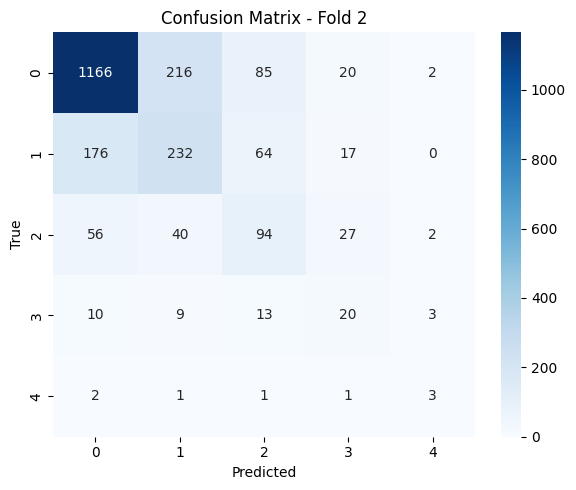

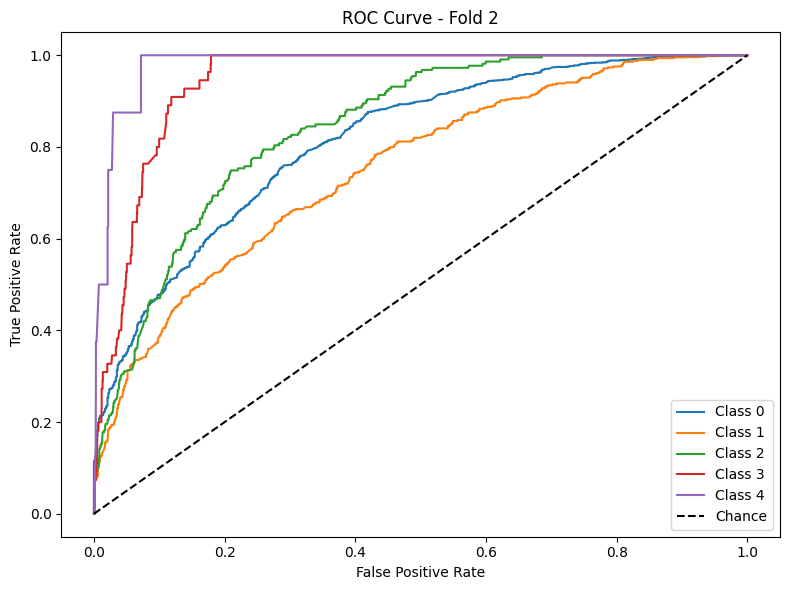


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      1489
           1       0.44      0.41      0.43       489
           2       0.43      0.53      0.47       219
           3       0.25      0.31      0.28        54
           4       0.20      0.38      0.26         8

    accuracy                           0.67      2259
   macro avg       0.43      0.49      0.45      2259
weighted avg       0.68      0.67      0.68      2259



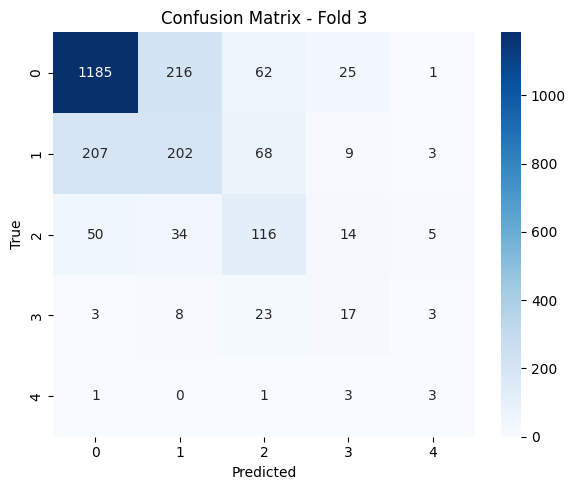

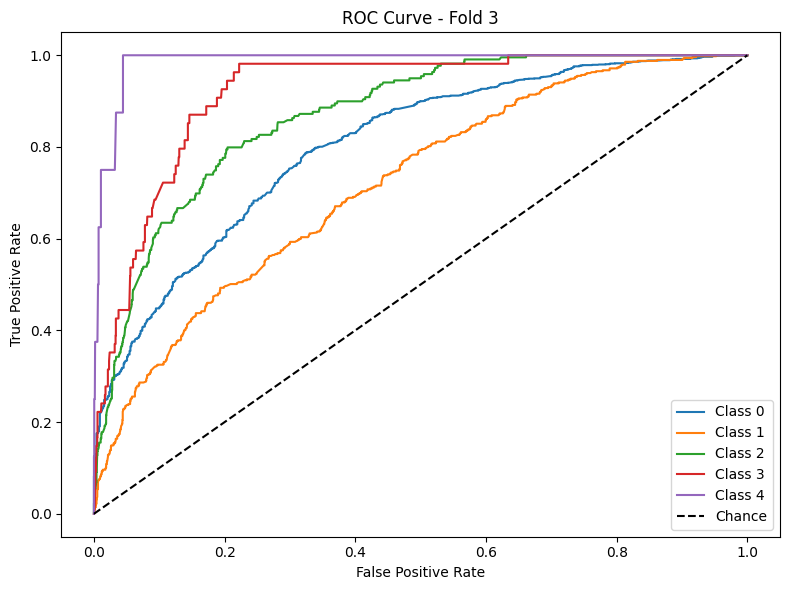


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.80      1489
           1       0.46      0.43      0.44       489
           2       0.38      0.48      0.43       219
           3       0.34      0.44      0.38        54
           4       0.31      0.50      0.38         8

    accuracy                           0.67      2259
   macro avg       0.46      0.53      0.49      2259
weighted avg       0.68      0.67      0.67      2259



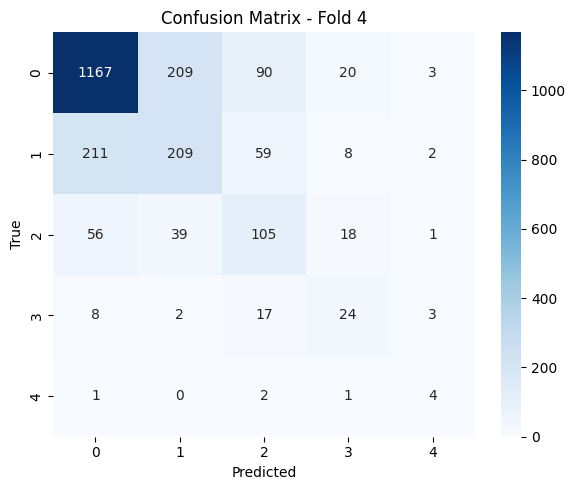

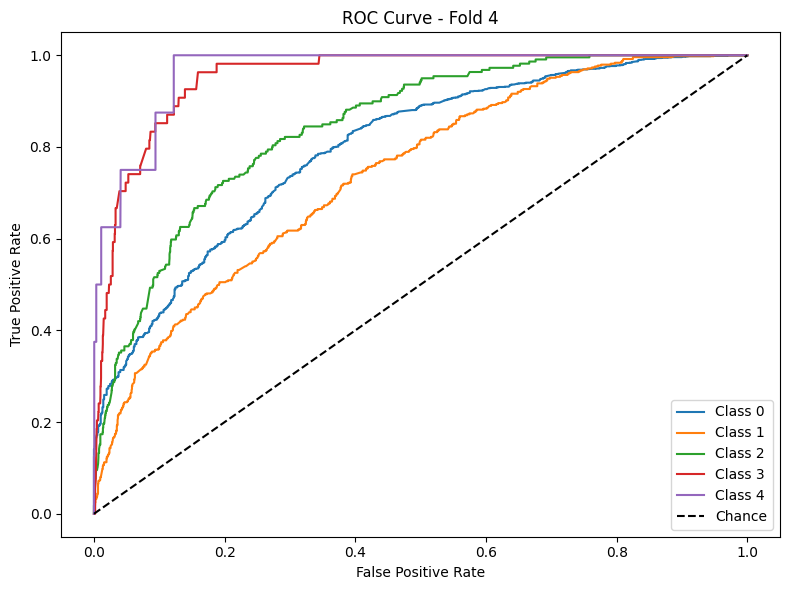


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      1490
           1       0.50      0.49      0.49       488
           2       0.42      0.54      0.47       219
           3       0.19      0.19      0.19        54
           4       0.10      0.12      0.11         8

    accuracy                           0.70      2259
   macro avg       0.41      0.43      0.42      2259
weighted avg       0.71      0.70      0.70      2259



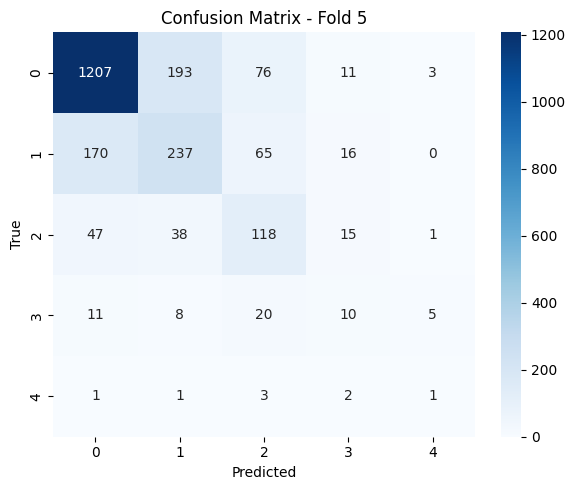

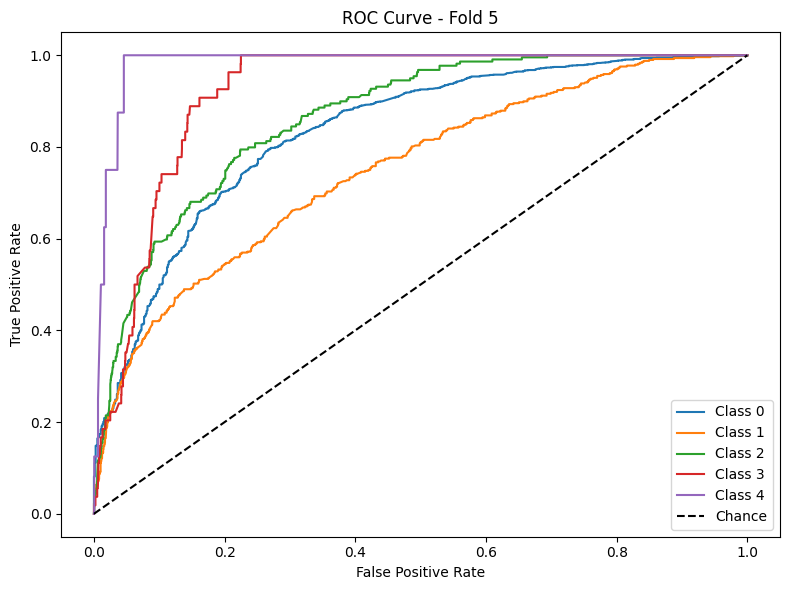


Average Accuracy: 0.6770
Average F1 Macro: 0.4529
Average AUC: 0.8633

Feature Importances:
video                                  0.146771
certificate                            0.097674
exam                                   0.092343
encoded_field_sum                      0.043352
exercise_attempts_sum_mean_2           0.040188
assignment                             0.037962
num_prerequisites                      0.036313
total_negative2                        0.027998
exercise_num_problem_sum_1             0.027334
exercise_attempts_sum_mean_1           0.024239
chapter_count                          0.023912
exercise_count                         0.022763
exercise_correct_mean_1                0.022339
user_month                             0.018944
degree                                 0.017974
exercise_correct_sum_2                 0.015356
exercise_correct_sum_1                 0.015076
duration_days                          0.014269
exercise_id_count_1                    0.01

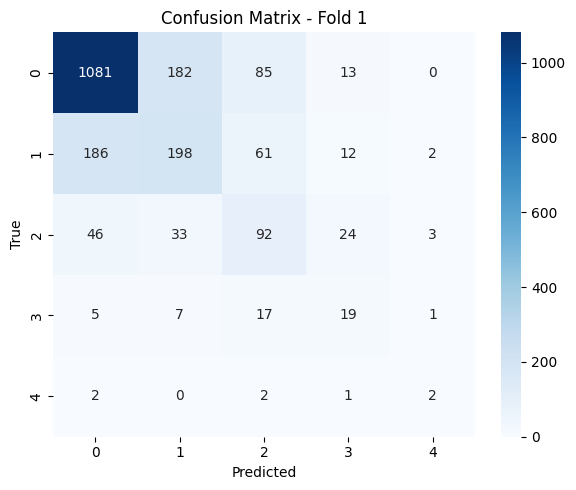

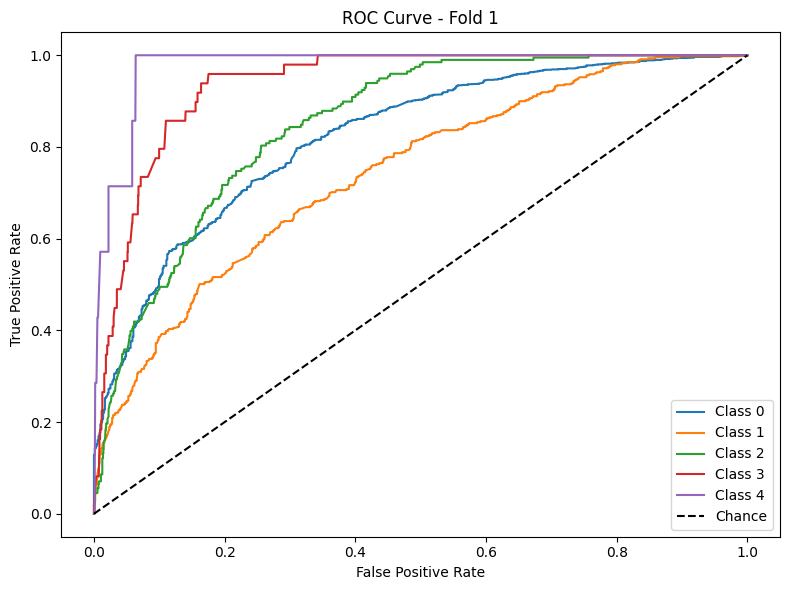


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1360
           1       0.49      0.44      0.46       459
           2       0.39      0.47      0.43       198
           3       0.38      0.40      0.39        50
           4       0.17      0.14      0.15         7

    accuracy                           0.68      2074
   macro avg       0.45      0.45      0.45      2074
weighted avg       0.69      0.68      0.68      2074



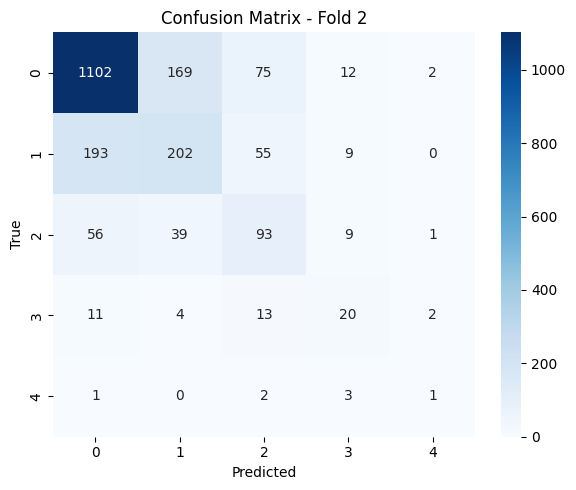

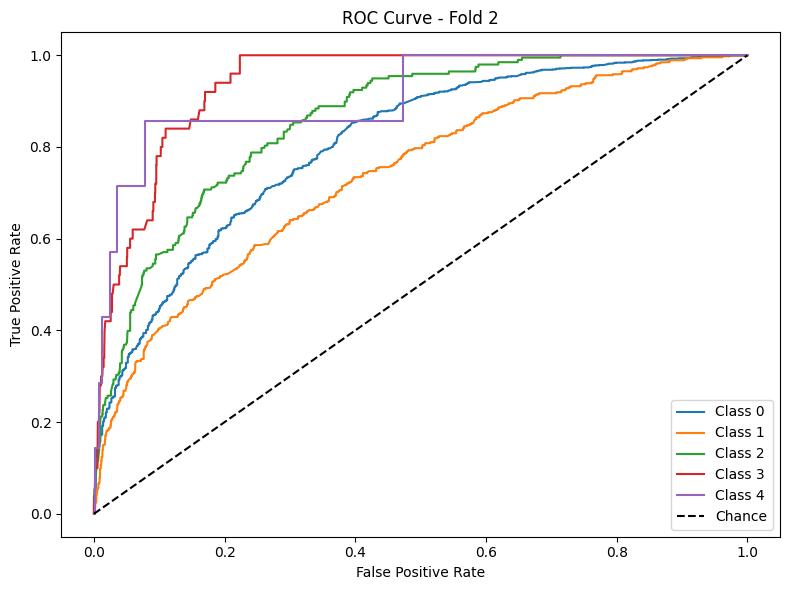


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1360
           1       0.43      0.39      0.41       459
           2       0.33      0.37      0.35       198
           3       0.29      0.36      0.32        50
           4       0.25      0.29      0.27         7

    accuracy                           0.66      2074
   macro avg       0.42      0.44      0.43      2074
weighted avg       0.66      0.66      0.66      2074



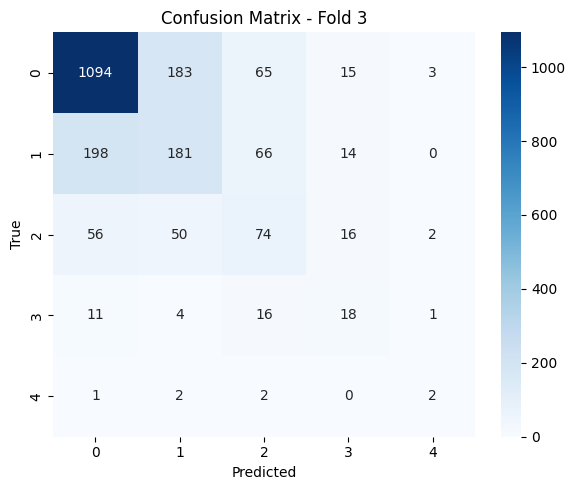

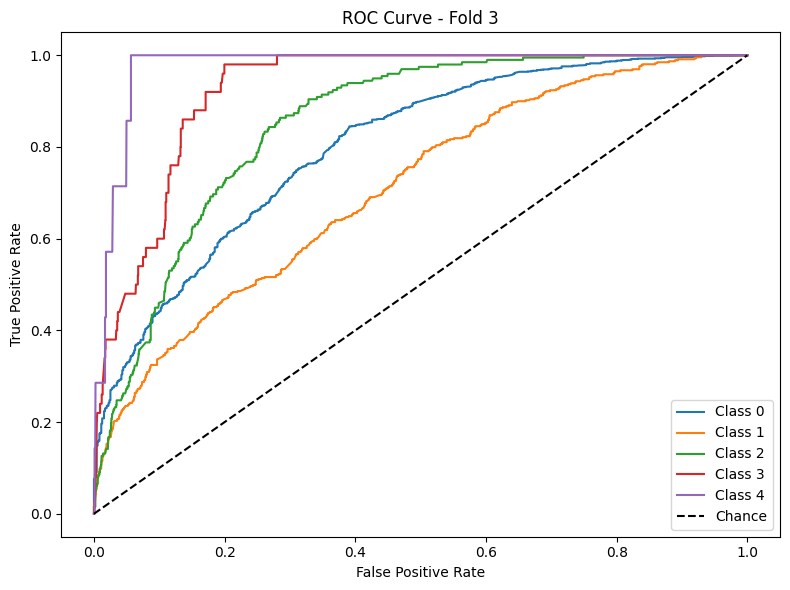


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      1360
           1       0.43      0.43      0.43       459
           2       0.41      0.45      0.43       198
           3       0.27      0.38      0.31        50
           4       0.25      0.14      0.18         7

    accuracy                           0.66      2074
   macro avg       0.43      0.44      0.43      2074
weighted avg       0.67      0.66      0.66      2074



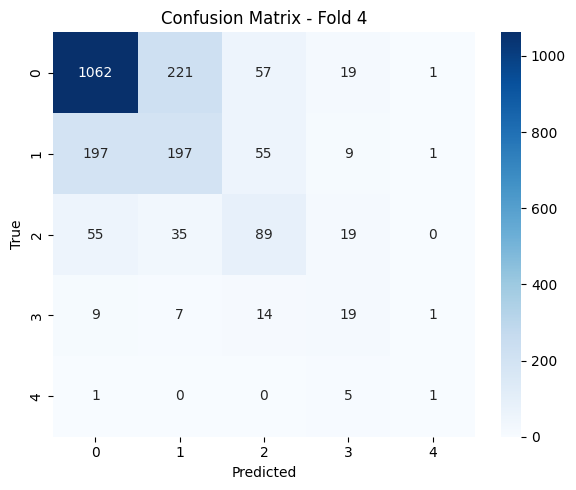

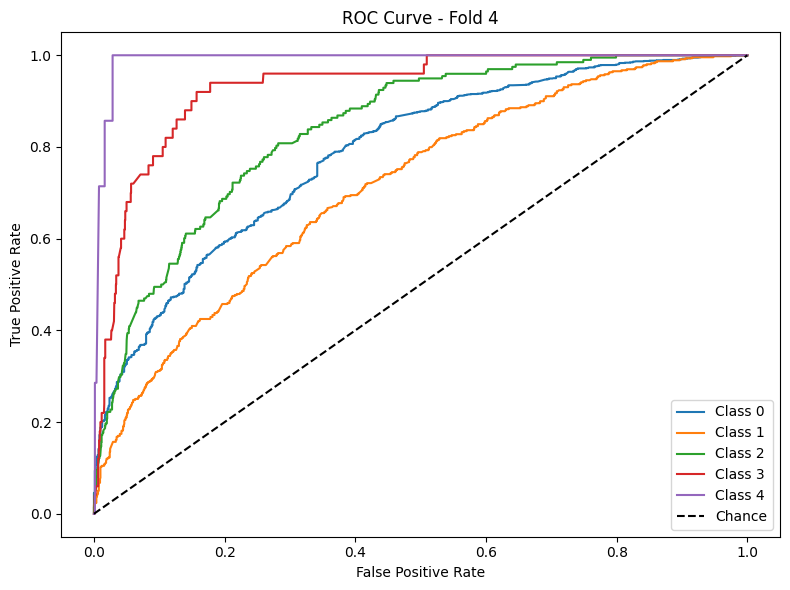


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79      1360
           1       0.44      0.46      0.45       460
           2       0.40      0.50      0.44       197
           3       0.29      0.41      0.34        49
           4       0.14      0.14      0.14         7

    accuracy                           0.66      2073
   macro avg       0.42      0.45      0.43      2073
weighted avg       0.68      0.66      0.67      2073



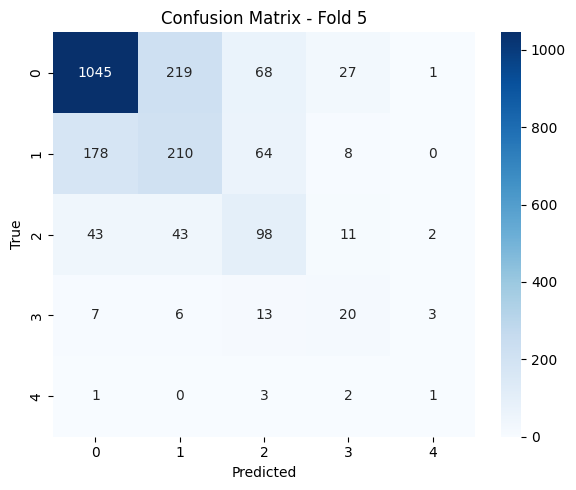

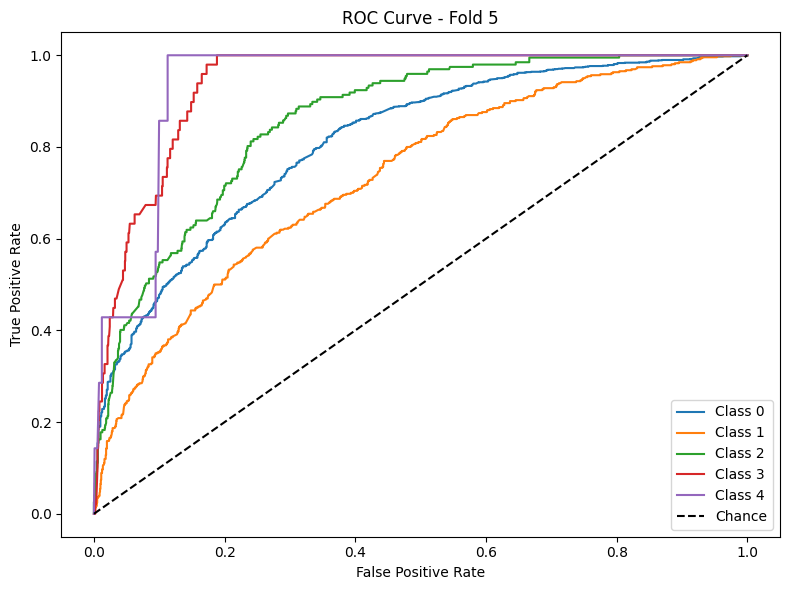


Average Accuracy: 0.6675
Average F1 Macro: 0.4384
Average AUC: 0.8553

Feature Importances:
video                                  0.116380
assignment                             0.087463
exam                                   0.086356
exercise_num_problem_sum_1             0.039866
certificate                            0.036628
exercise_correct_sum_2                 0.029884
chapter_count                          0.029264
exercise_langugage_binary_mean_2       0.022386
encoded_field_sum                      0.021086
exercise_context_sum_1                 0.019187
num_prerequisites                      0.017739
exercise_count                         0.017233
exercise_correct_sum_1                 0.017159
exercise_perc_real_score_mean_1        0.016702
exercise_hour_entropy_3                0.016539
exercise_correct_sum_3                 0.016118
exercise_correct_mean_3                0.015686
exercise_id_count_2                    0.015554
exercise_id_count_1                    0.01

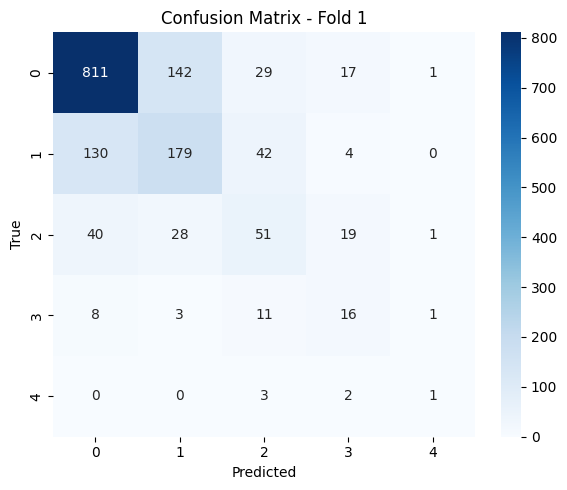

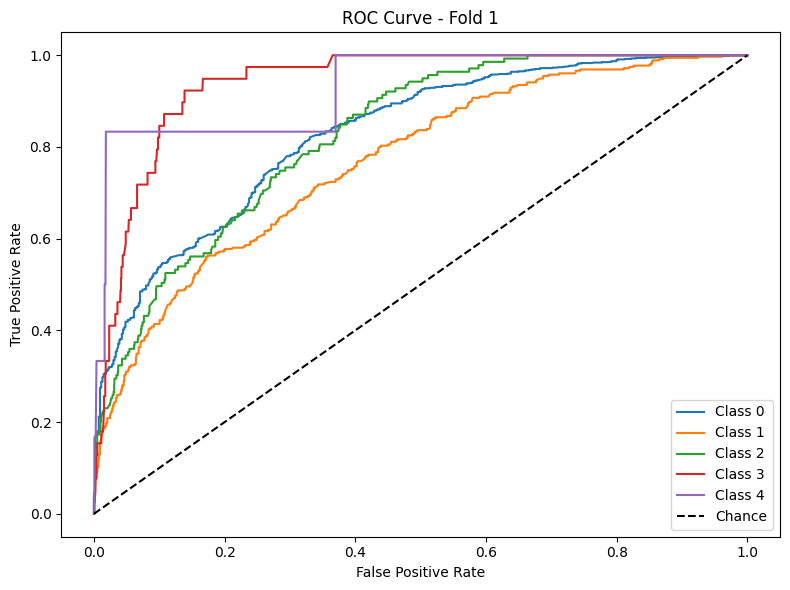


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      1000
           1       0.47      0.48      0.48       355
           2       0.46      0.47      0.46       139
           3       0.37      0.42      0.40        40
           4       0.07      0.20      0.10         5

    accuracy                           0.68      1539
   macro avg       0.44      0.47      0.45      1539
weighted avg       0.69      0.68      0.69      1539



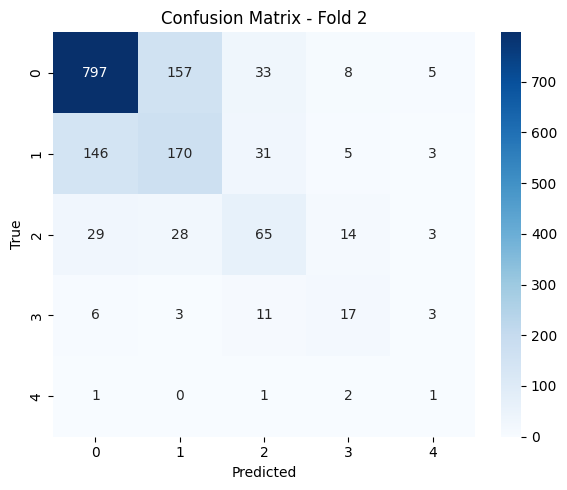

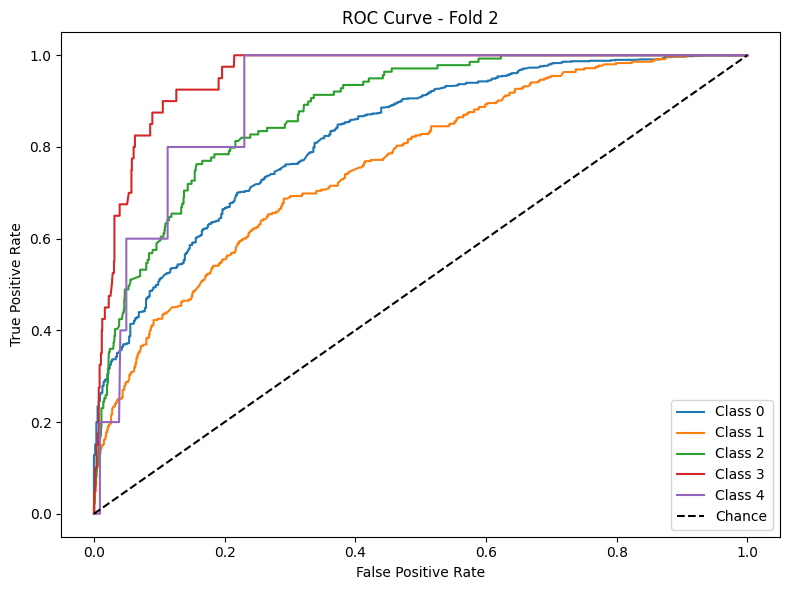


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81       999
           1       0.49      0.49      0.49       355
           2       0.47      0.47      0.47       139
           3       0.38      0.47      0.42        40
           4       0.00      0.00      0.00         6

    accuracy                           0.69      1539
   macro avg       0.43      0.45      0.44      1539
weighted avg       0.69      0.69      0.69      1539



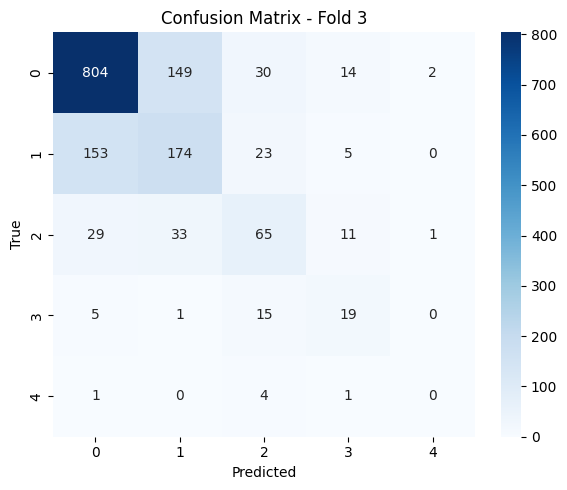

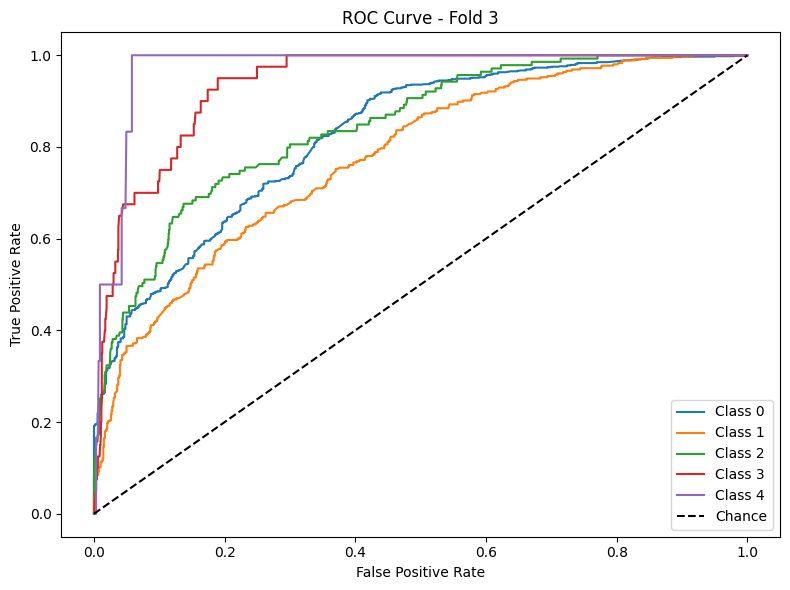


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       999
           1       0.51      0.48      0.49       356
           2       0.43      0.44      0.44       138
           3       0.33      0.41      0.36        39
           4       0.25      0.50      0.33         6

    accuracy                           0.70      1538
   macro avg       0.47      0.53      0.49      1538
weighted avg       0.70      0.70      0.70      1538



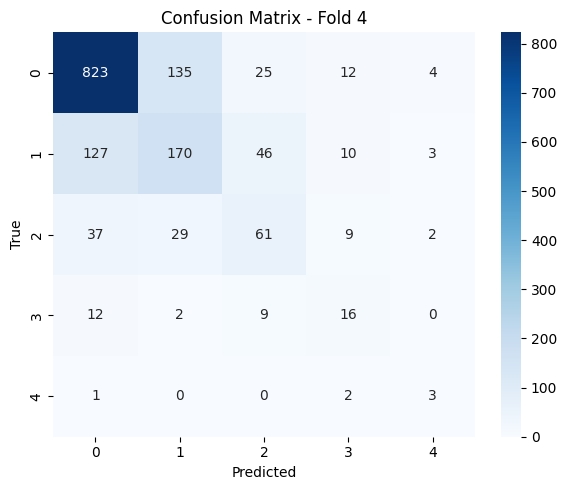

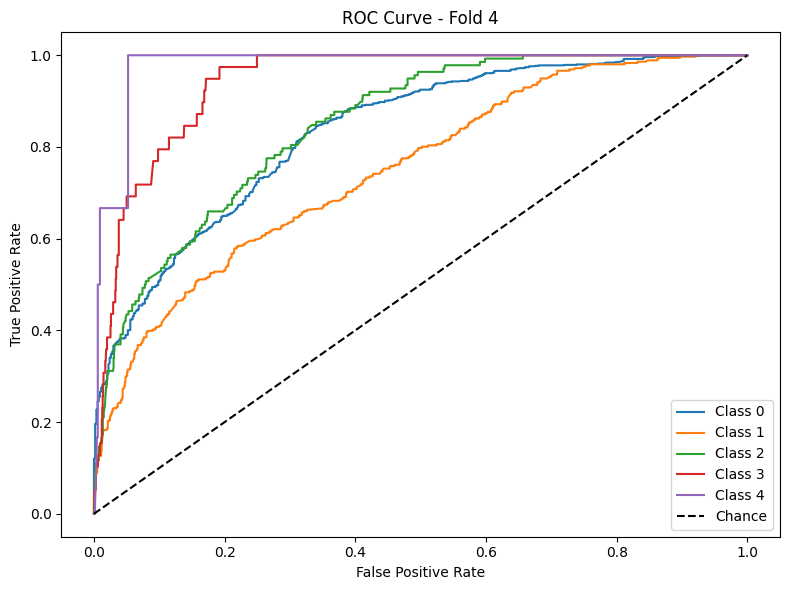


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83       999
           1       0.51      0.51      0.51       356
           2       0.40      0.46      0.43       138
           3       0.40      0.51      0.45        39
           4       0.00      0.00      0.00         6

    accuracy                           0.70      1538
   macro avg       0.43      0.46      0.44      1538
weighted avg       0.71      0.70      0.71      1538



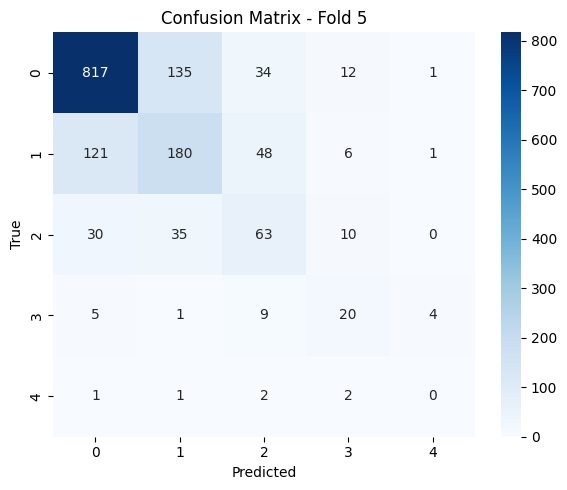

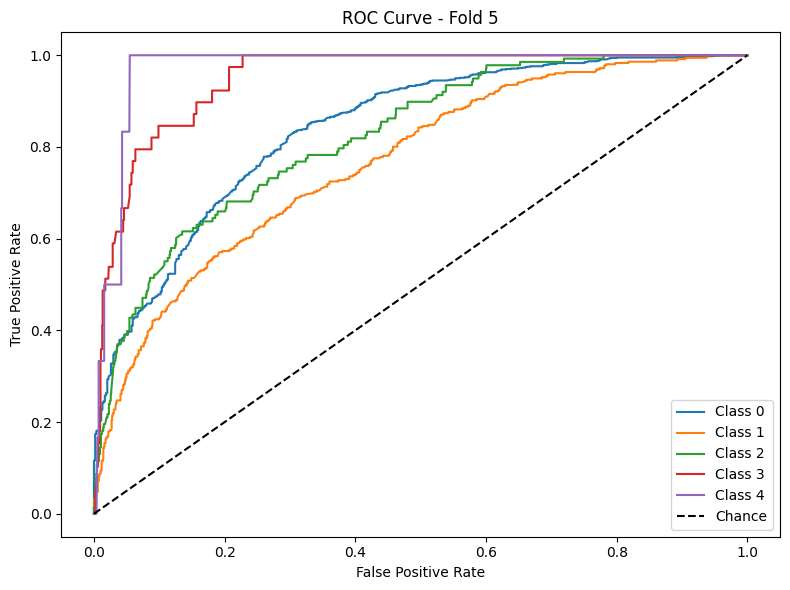


Average Accuracy: 0.6919
Average F1 Macro: 0.4527
Average AUC: 0.8672

Feature Importances:
video                                  0.143857
assignment                             0.125718
encoded_field_sum                      0.048023
num_prerequisites                      0.027502
exam                                   0.026257
video_count                            0.024928
exercise_count                         0.023391
certificate                            0.021342
degree                                 0.020471
closeness                              0.018951
end_year                               0.017545
chapter_count                          0.017095
exercise_correct_sum_2                 0.015889
exercise_num_problem_sum_1             0.015768
exercise_attempts_sum_mean_4           0.014408
total_negative4                        0.014036
exercise_correct_sum_1                 0.013840
exercise_id_count_1                    0.013646
exercise_hour_entropy_2                0.01

In [9]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       568
           1       0.33      0.29      0.31        63
           2       0.31      0.21      0.25        43
           3       0.00      0.00      0.00        15
           4       0.14      0.11      0.12         9

    accuracy                           0.80       698
   macro avg       0.33      0.31      0.32       698
weighted avg       0.77      0.80      0.78       698



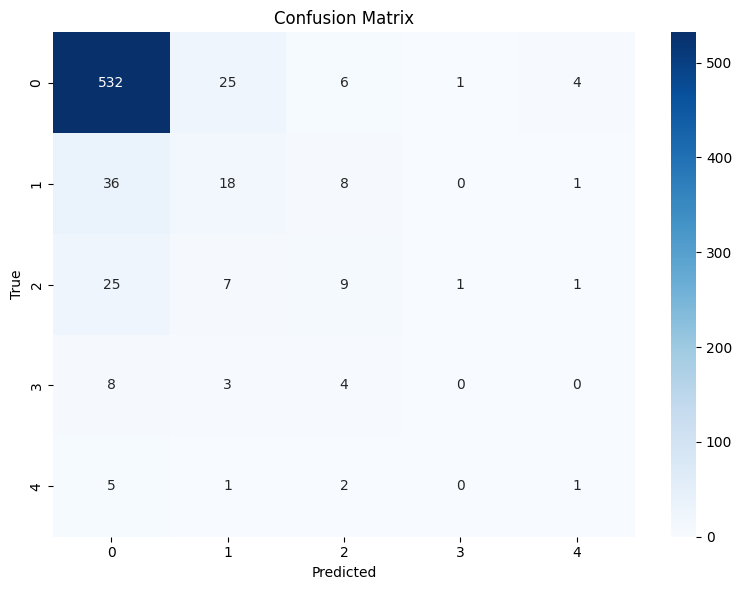


Test AUC (macro-average, OVR): 0.8408


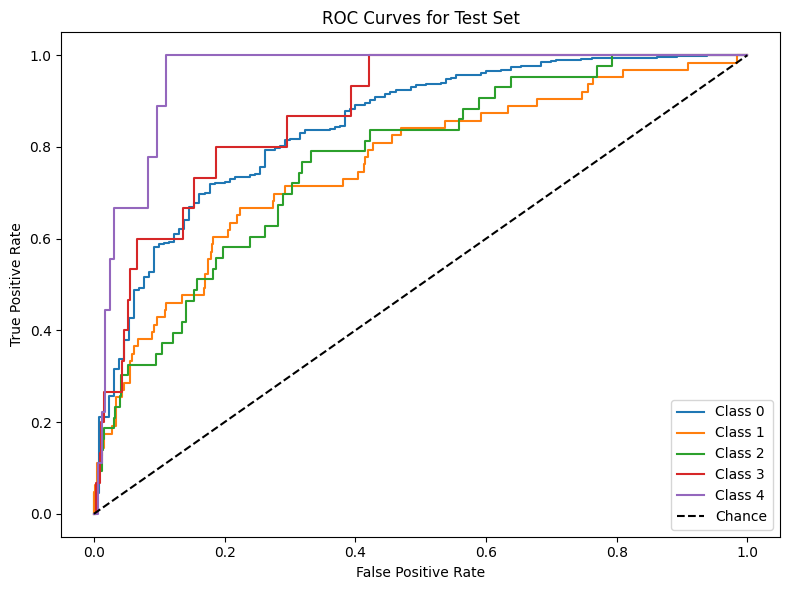


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       544
           1       0.35      0.27      0.30        59
           2       0.33      0.36      0.34        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.82       668
   macro avg       0.32      0.32      0.31       668
weighted avg       0.78      0.82      0.80       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


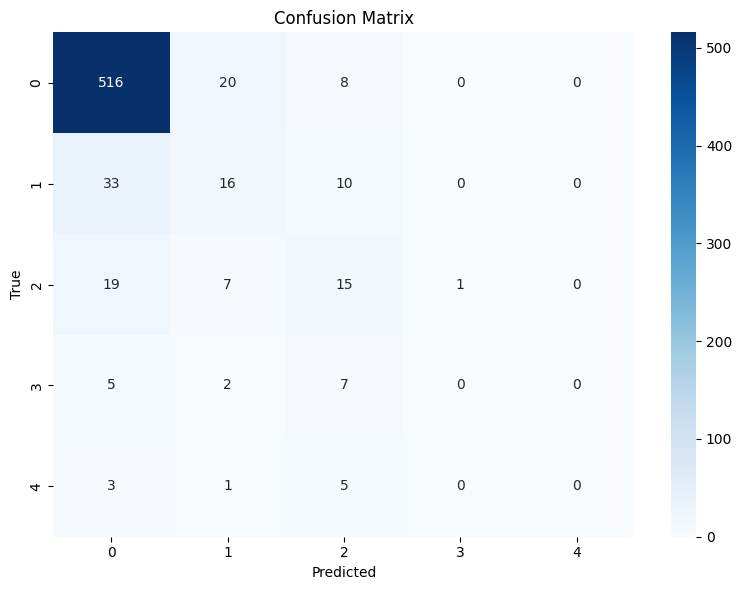


Test AUC (macro-average, OVR): 0.8558


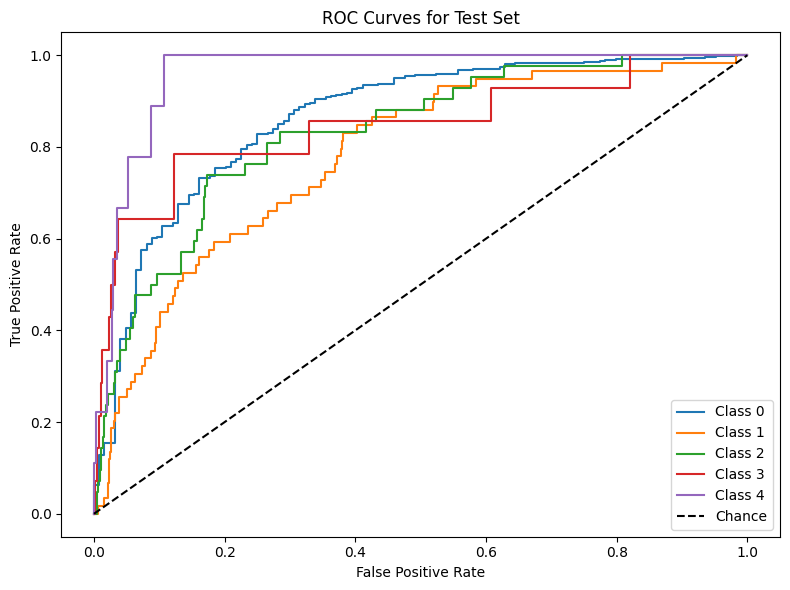


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       455
           1       0.22      0.15      0.18        52
           2       0.25      0.07      0.11        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.79       554
   macro avg       0.26      0.23      0.24       554
weighted avg       0.73      0.79      0.76       554



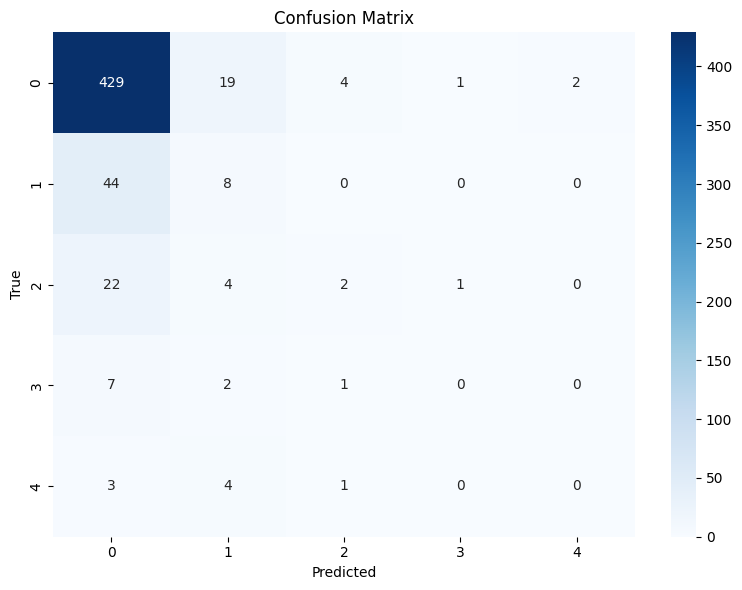


Test AUC (macro-average, OVR): 0.7390


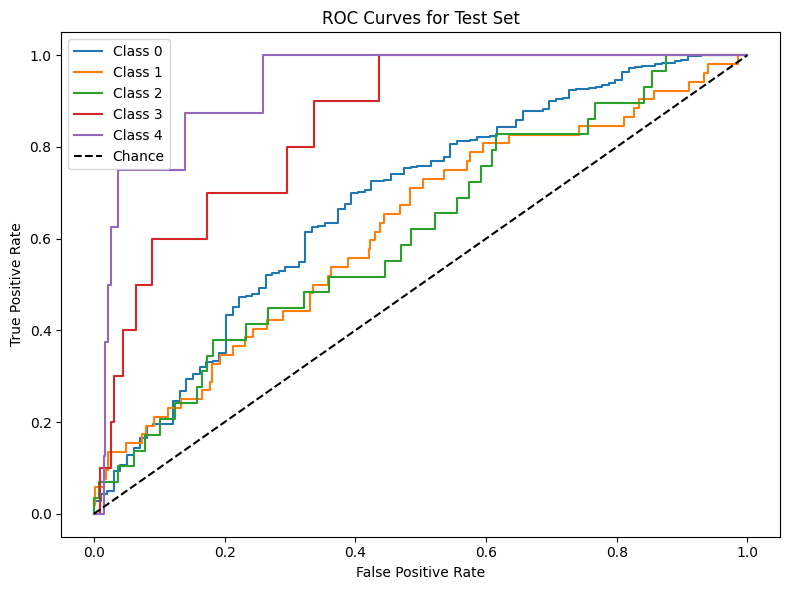


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       395
           1       0.13      0.10      0.11        40
           2       0.24      0.21      0.22        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.79       477
   macro avg       0.25      0.25      0.25       477
weighted avg       0.74      0.79      0.77       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


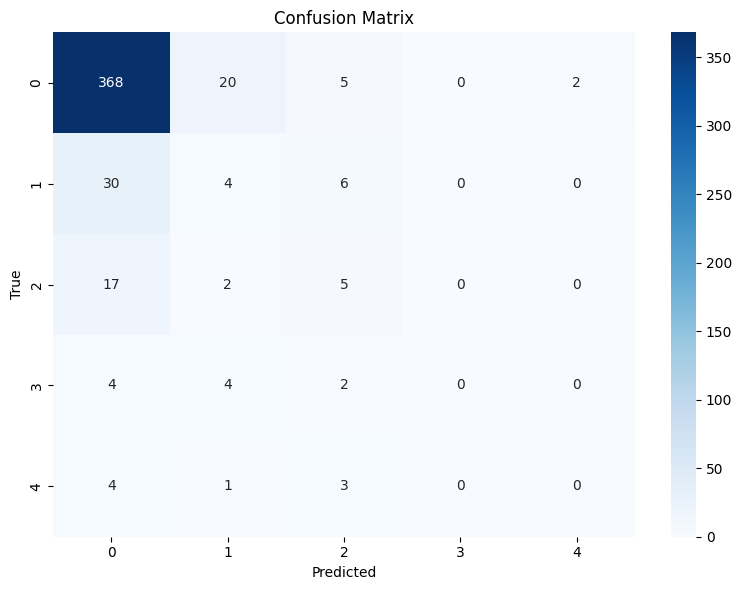


Test AUC (macro-average, OVR): 0.7839


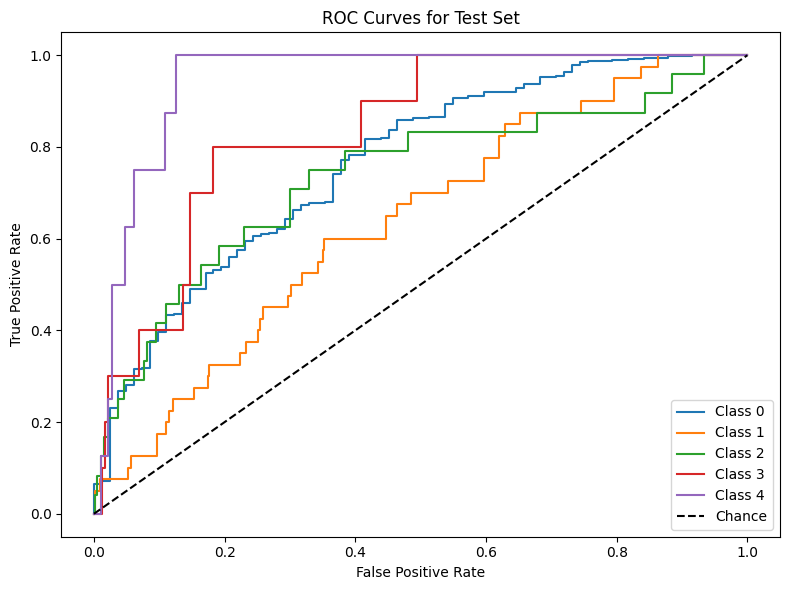

In [10]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)